In [1]:
__author__ = 'Shi Fan, Diogo Miura, Federica Bianco'
import glob
import pandas as pd, numpy as np
import pylab as pl
%pylab inline
from scipy import signal
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loading photos taken with shutter frequency 120, 119.75, 119, 100, 50 and 10 Hz; and camera frequency of 4 and 3.5hz 
#Special case for 119.75, because we saved the images as "11975"

shutter = [120, 119.75, 119, 100, 50, 10]

photo_files4 = {}
photo_files35 = {}

for i in shutter:
    if i == 119.75:
        path4 = '/scratch/share/fbianco/LEDtest/s%shz_c4hz*.raw' % 11975
        path35 = '/scratch/share/fbianco/LEDtest/s%shz_c35hz*.raw' % 11975
    else:
        path4 = '/scratch/share/fbianco/LEDtest/s%shz_c4hz*.raw' % i
        path35 = '/scratch/share/fbianco/LEDtest/s%shz_c35hz*.raw' % i
    photo_files4[i] = glob.glob(path4)
    photo_files35[i] = glob.glob(path35)

In [3]:
#Converting series into Numpy arrays

photo_arrays4 = {}
photo_arrays35 = {}

for key, value in photo_files4.iteritems():
    photo_arrays4[key] = np.array(value)[np.argsort(value)] 
    
for key, value in photo_files35.iteritems():
    photo_arrays35[key] = np.array(value)[np.argsort(value)] 

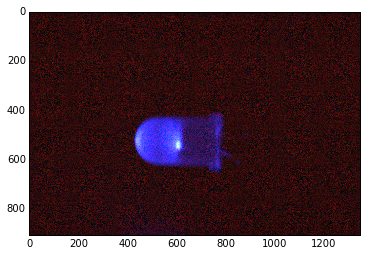

In [4]:
#Testing several configurations to find the right nrow/ncol

nrow = 908
ncol = 1344
nband = 3

pl.figure()
pl.imshow(np.fromfile(photo_arrays35[119.75][250], dtype=np.uint8).reshape(nrow, ncol, nband))
pl.show()

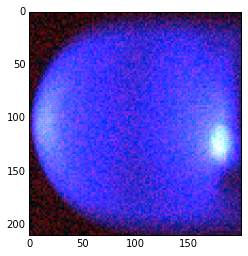

In [5]:
#Testing image size so as to crop "non-lamp" parts 

pl.imshow(np.fromfile(photo_arrays35[119.75][250],dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])
pl.show()

In [6]:
#Resizing all series
#Excluding 119/3.5 Hz setting as it is crashing (possibly because of missing photos)

photo_resized4 = {}
photo_resized35 = {}

for key, value in photo_arrays4.iteritems():
    photo_resized4[key] = np.zeros(len(value))

for key, value in photo_arrays35.iteritems():
    if key != 119:
        photo_resized35[key] = np.zeros(len(value))

for r in photo_resized4:
    for i,f in enumerate(photo_arrays4[r]):
        photo_resized4[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])        
        pkl.dump(value, open('/scratch/share/fbianco/ht_pickles/photo_resized_4c_'+str(r)+'s.pkl', 'wb')) 
        
for r in photo_resized35:
    for i,f in enumerate(photo_arrays35[r]):
        photo_resized35[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])
        pkl.dump(value, open('/scratch/share/fbianco/ht_pickles/photo_resized_35c_'+str(r)+'s.pkl', 'wb')) 

## Flux vs Image Number

In [7]:
#Creating dictionaries for flux
#Normalizing flux by (flux-mean)/std

flux4 = {}
flux35 = {}

def mynorm(flux):
    flux -= flux.mean()
    return 2*(flux-flux.min())/(flux.max()-flux.min())

for key, value in photo_resized4.iteritems():
    flux4[key] = mynorm(value)

for key, value in photo_resized35.iteritems():
    flux35[key] = mynorm(value)

In [8]:
def plot_flux_by_img_num(flux, c_freq):
    for key, value in flux.iteritems():
        pl.figure(figsize=(20,5))
        pl.plot(value, '-', color='dodgerblue', linewidth=0.75)
        pl.plot(value, 'o', color='dodgerblue')
        pl.xlabel("Image number", fontsize=15)
        pl.ylabel("Almost normalized flux", fontsize=15)
        pl.title('Flux: Shutter '+str(key)+'Hz; Camera: '+str(c_freq)+'Hz', fontsize=20)
        pl.ylim(-.1,2.1)
        pl.show()

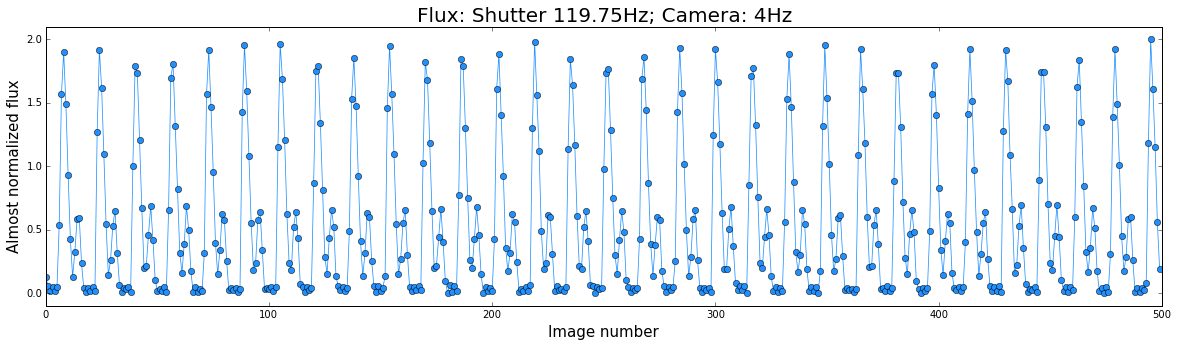

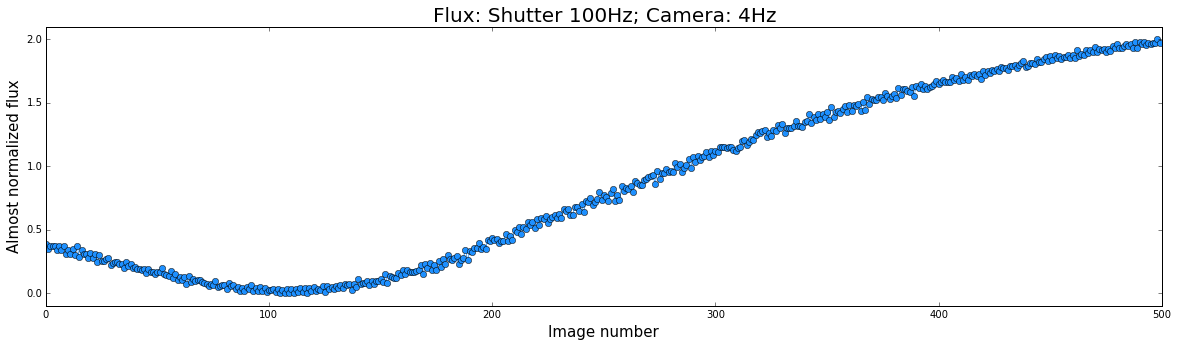

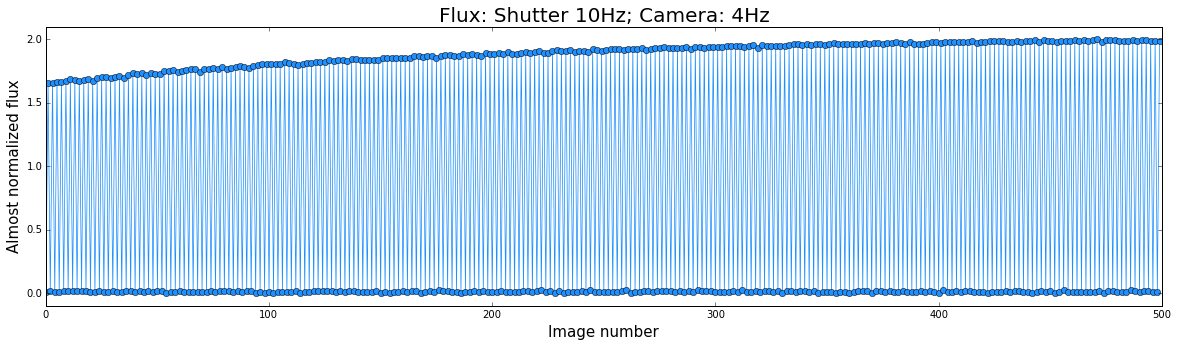

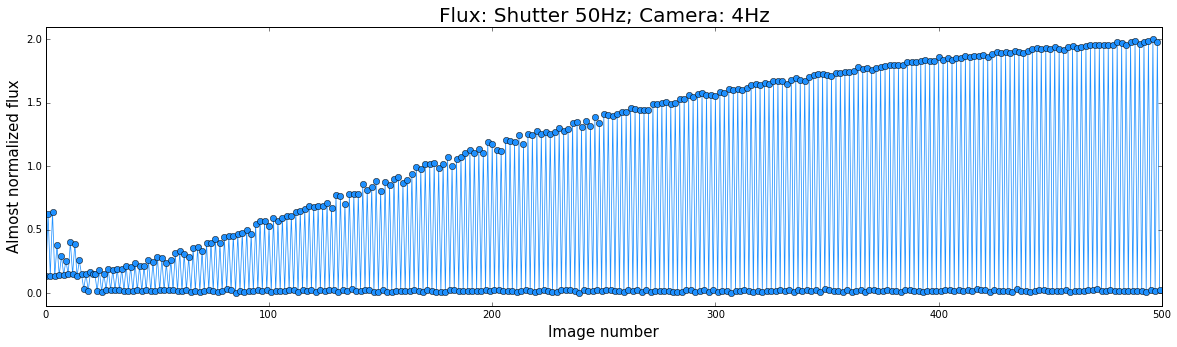

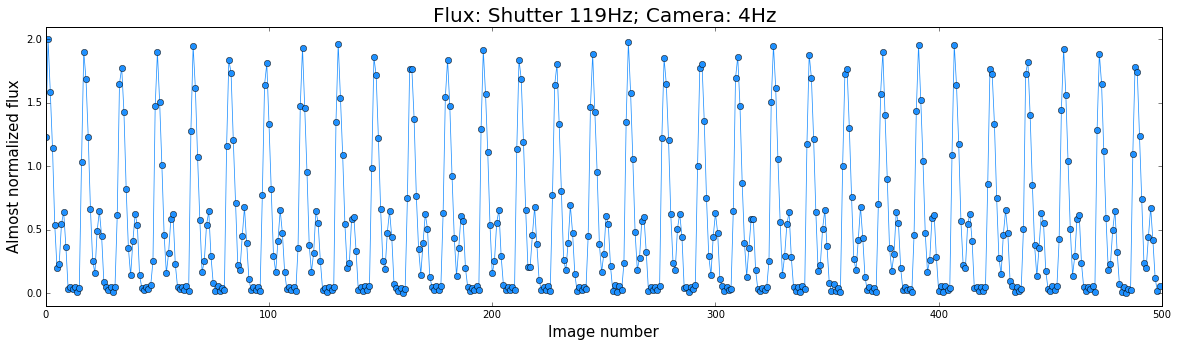

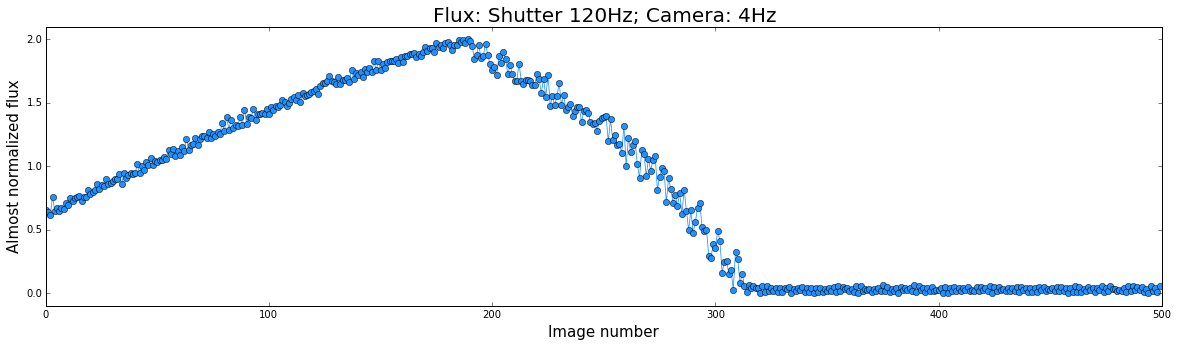

In [9]:
plot_flux_by_img_num(flux4, 4)

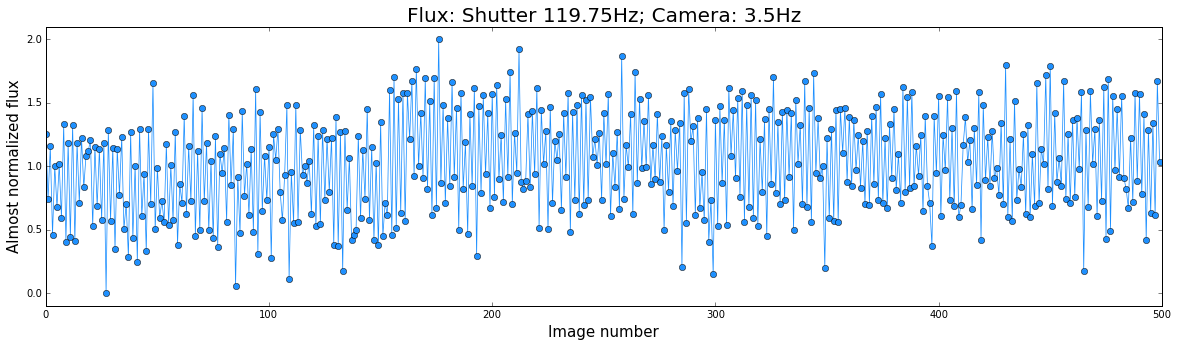

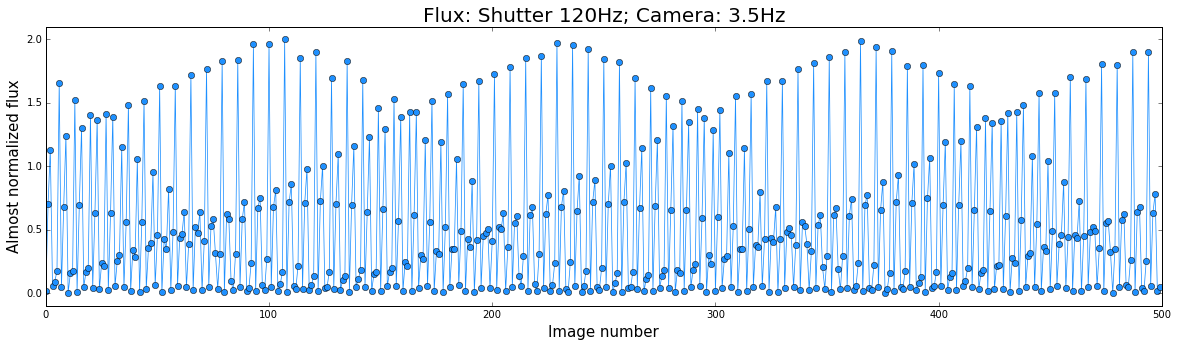

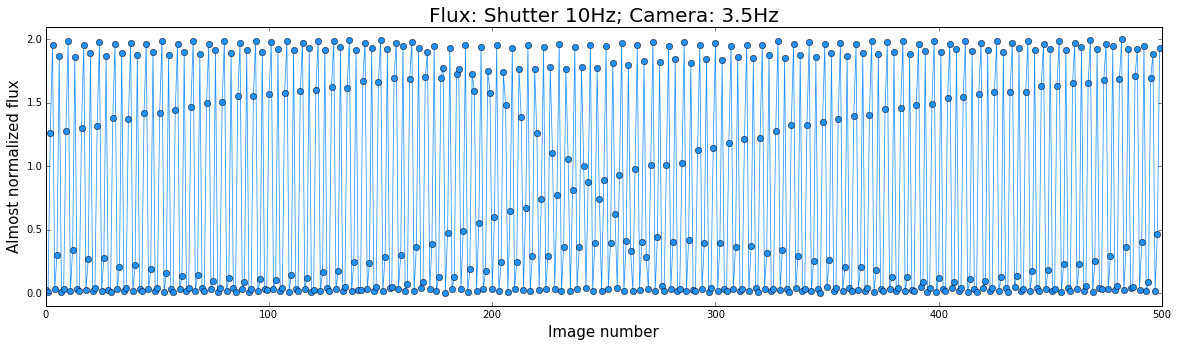

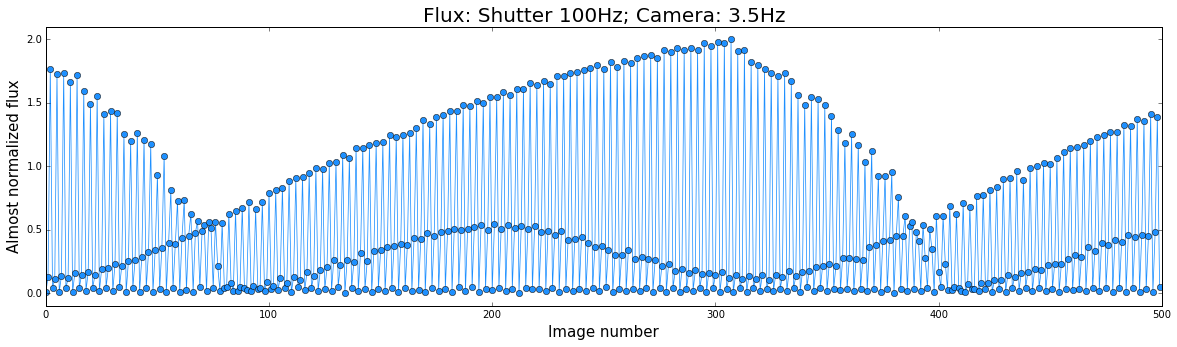

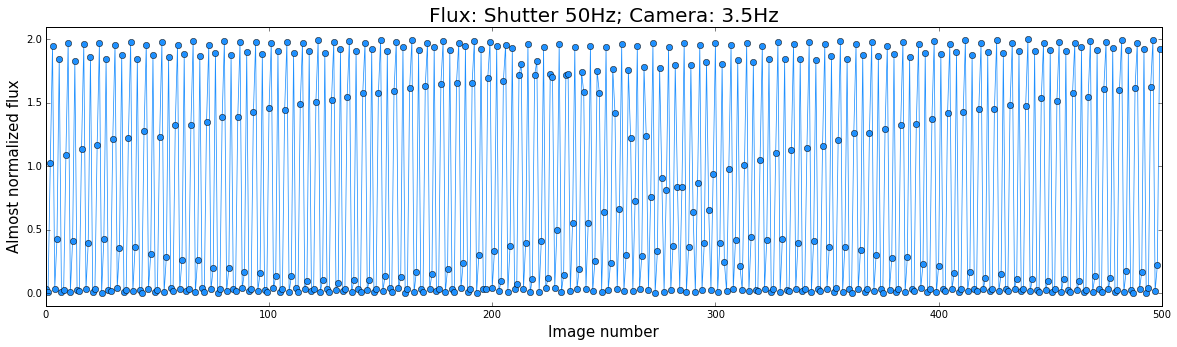

In [10]:
plot_flux_by_img_num(flux35, 3.5)

## Flux vs Time

In [11]:
#Calculating the runtime

runtime4 = np.linspace(0, len(photo_resized4[10])/4, len(photo_resized4[10]), endpoint=True)
runtime35 = np.linspace(0, len(photo_resized35[10])/3.5, len(photo_resized35[10]), endpoint=True)

def plot_flux_by_runtime(flux, c_freq):
    for key, value in flux.iteritems():
        pl.figure(figsize=(20,5))
        if c_freq==4:
            pl.plot(runtime4, flux[key], '-', color='mediumorchid', linewidth=0.75)
            pl.plot(runtime4, flux[key], 'o', color='mediumorchid')
            pl.xlim(0,125)
        elif c_freq==3.5:
            pl.plot(runtime35, flux[key], '-', color='mediumorchid', linewidth=0.75)
            pl.plot(runtime35, flux[key], 'o', color='mediumorchid')
            pl.xlim(0,143)
        else:
            print 'Camera frequency has to be 4 or 3.5'
            break
        pl.xlabel("Seconds", fontsize=15)
        pl.ylabel("Almost normalized flux", fontsize=15)
        pl.title('Runtime: Shutter '+str(key)+'Hz; Camera: '+str(c_freq)+'Hz', fontsize=20)
        pl.ylim(-.1,2.1)
        pl.show() 

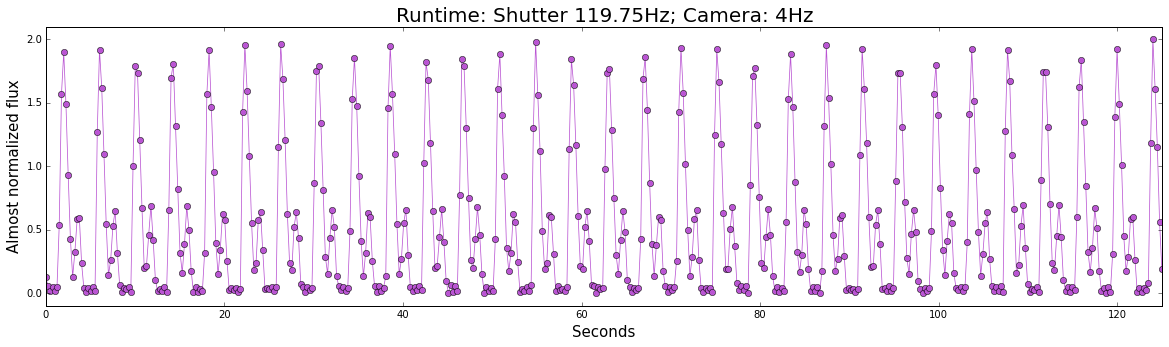

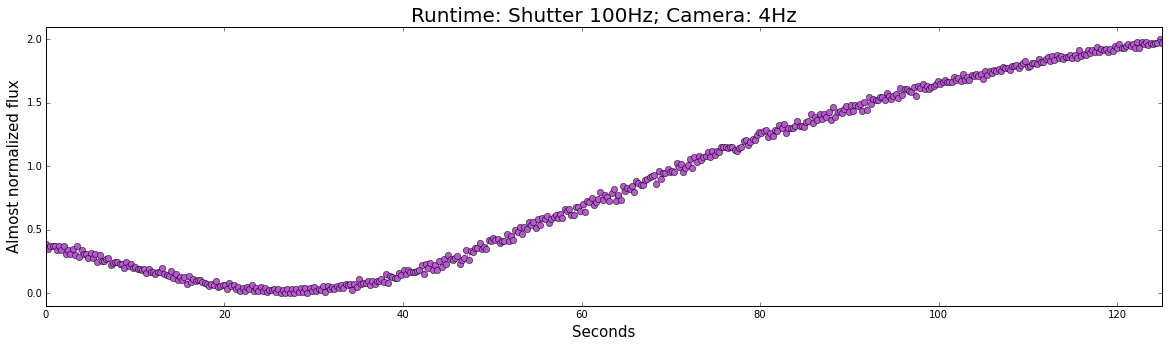

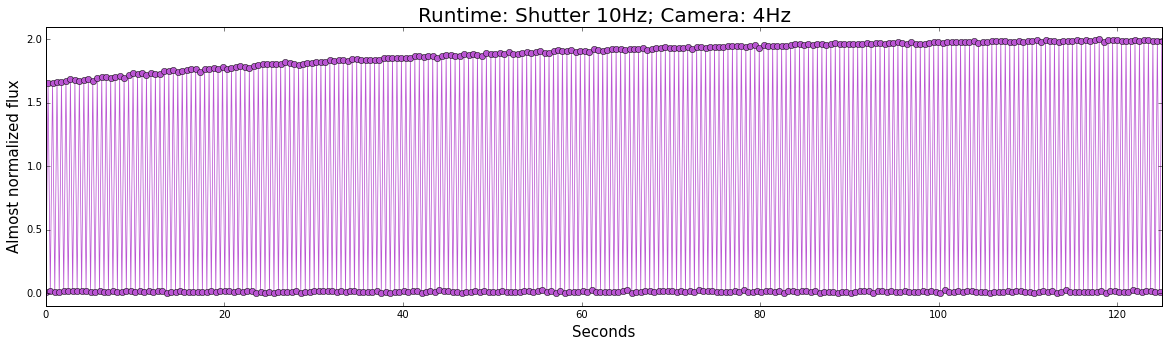

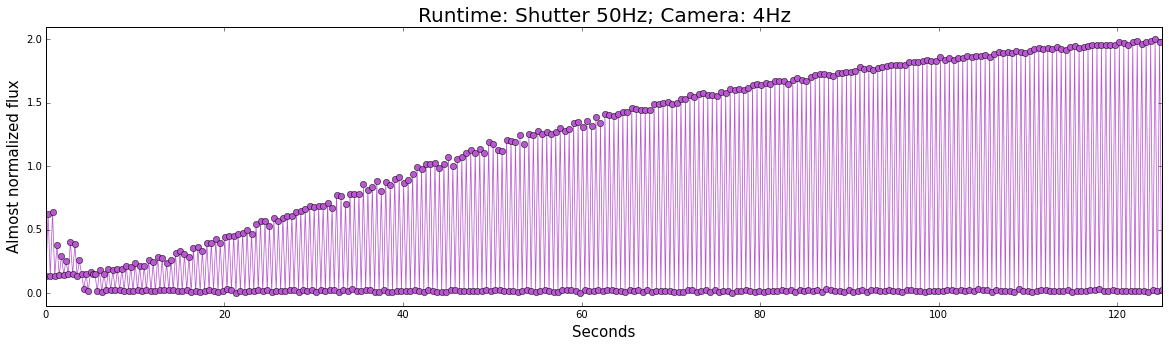

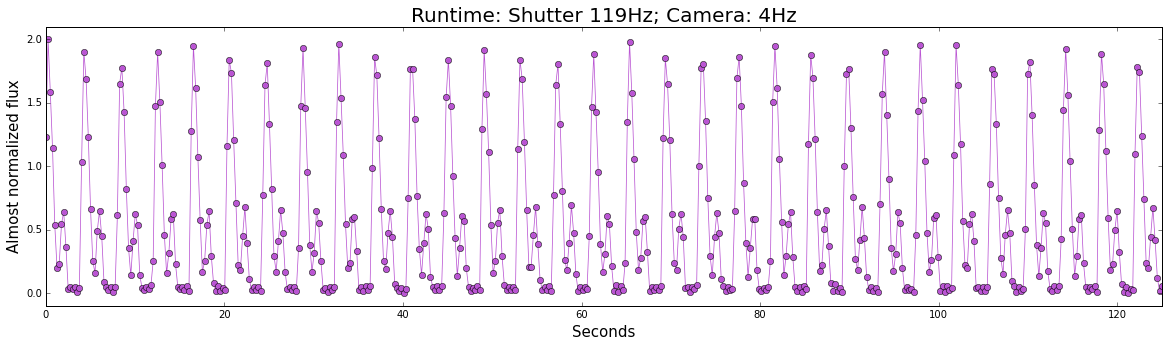

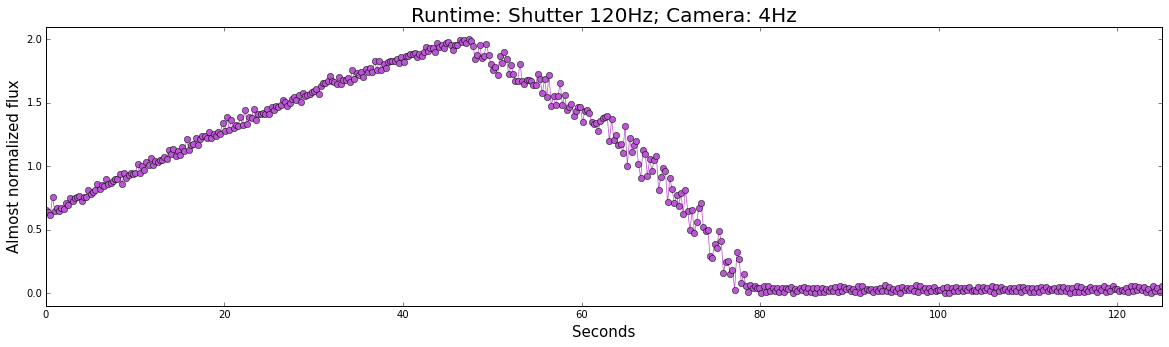

In [12]:
plot_flux_by_runtime(flux4, 4)

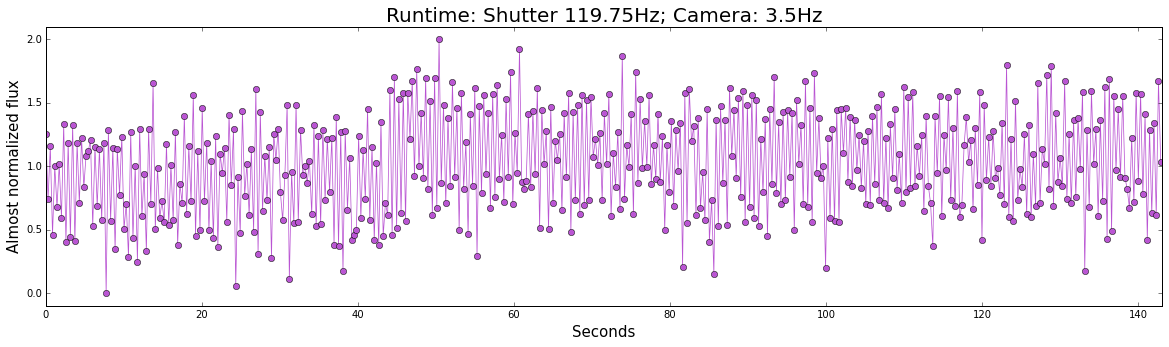

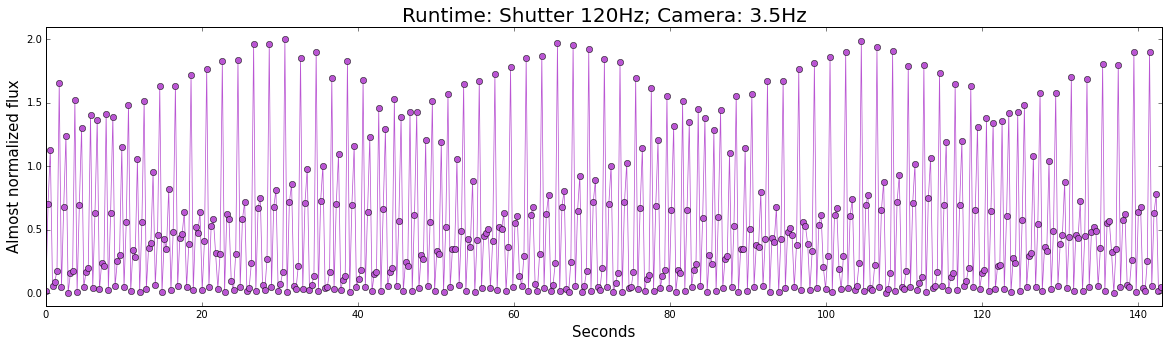

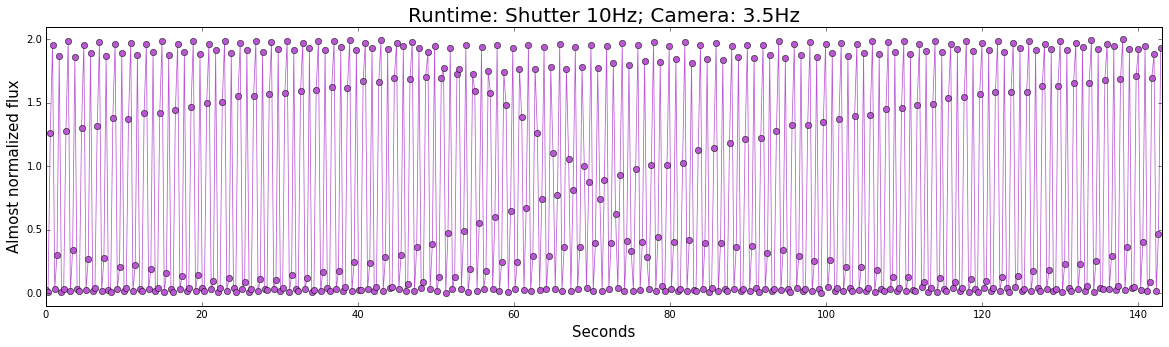

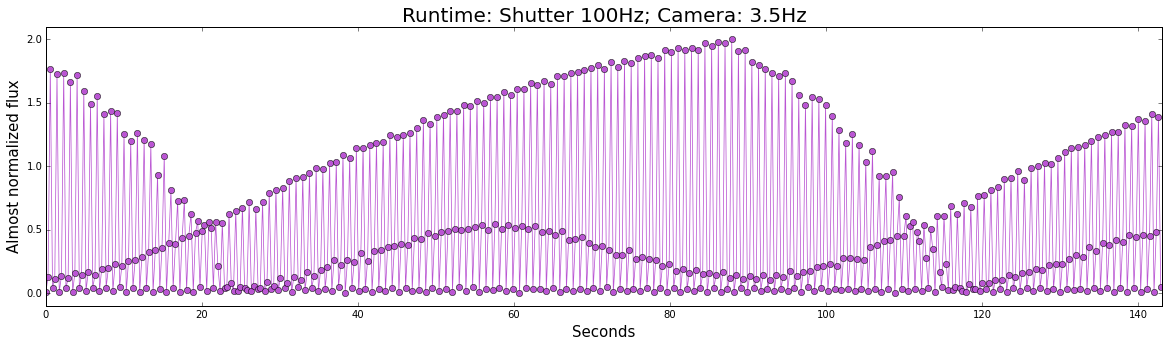

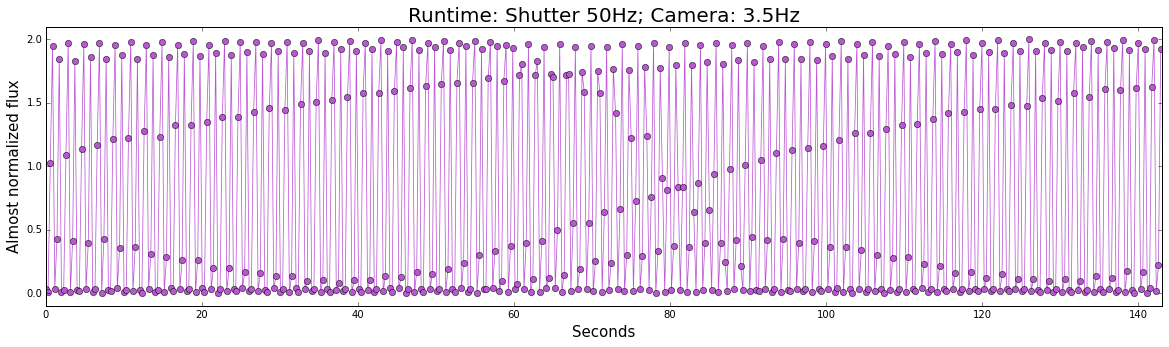

In [13]:
plot_flux_by_runtime(flux35, 3.5)

## Simulated flux

In [45]:
def sim_wave(w_type, time, freq, mag=1, phase=0):
    #print time.shape
    if w_type=='sine':
        wave = mag*np.sin(2*np.pi*freq*time+phase)+mag
    elif w_type=='square':
        wave = mag*signal.square(2*np.pi*freq*time+phase)+mag
    else:
        print 'Please enter sine or square for simulated wave type'
    return wave

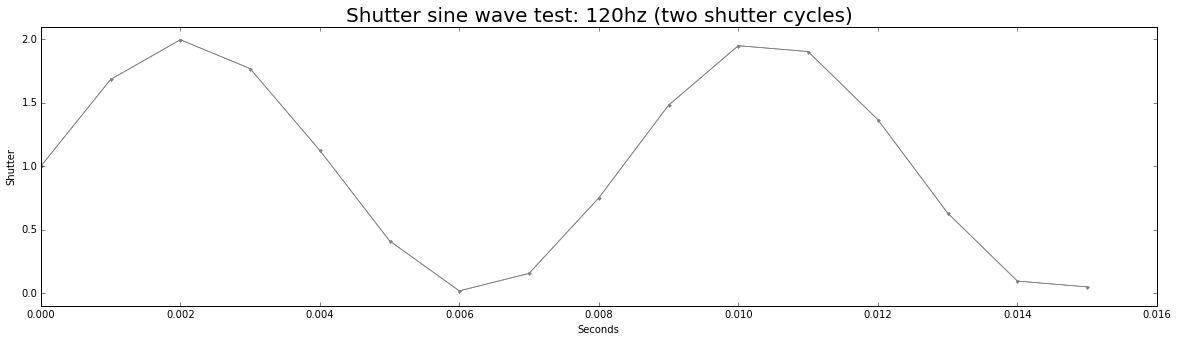

In [32]:
time = np.linspace(0, 150, 150*1000, endpoint=False)
for i in shutter:
    sine  = sim_wave('sine', time, i)
    nsteps = 2*int(1000/i)
    
    pl.figure(figsize=(20,5))
    pl.plot(time[:nsteps], sine[:nsteps], '-', color='grey', linewidth = 0.75)
    pl.plot(time[:nsteps], sine[:nsteps], '.-', color='grey', linewidth = 0.75)

    pl.title('Shutter sine wave test: %dhz (two shutter cycles)'%i, fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Shutter')
    pl.ylim(-.1, 2.1);

    break # loop successfully tested

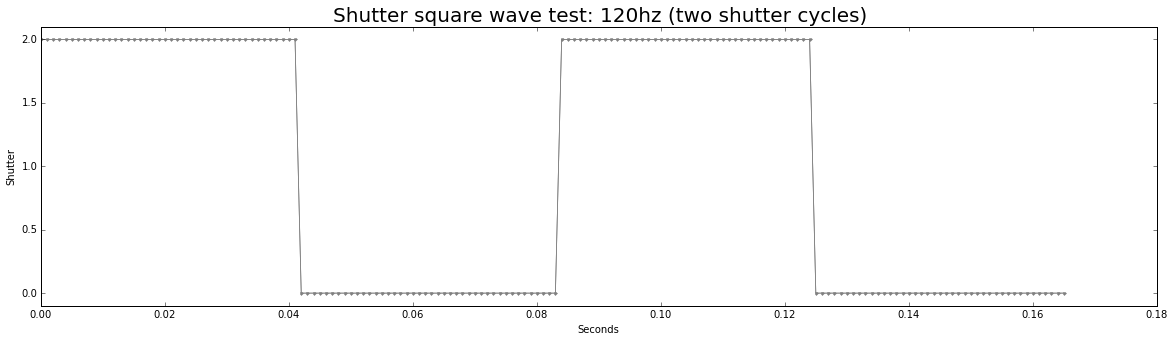

In [33]:
#I'm now trying to simulate square waves for the shutter
time2 = np.linspace(0, 150, 150*10000, endpoint=False)
for i in shutter:
    square  = sim_wave('square', time2, i)
    nsteps = 2*int(10000/i)

    pl.figure(figsize=(20,5))
    pl.plot(time[:nsteps], square[:nsteps], '-', color='grey', linewidth = 0.75)
    pl.plot(time[:nsteps], square[:nsteps], '.-', color='grey', linewidth = 0.75)

    pl.title('Shutter square wave test: %dhz (two shutter cycles)'%i, fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Shutter')
    pl.ylim(-.1, 2.1);
    
    break # loop successfully tested

## Simulated flux: camera "meets" the shutter wave

In [17]:
#I'm trying to find the flux that would be expected given the camera/shutter settings
#I'm dividing the analysis into the 2 camera speeds
#At the highest camera speed (4hz), the 500 photos take 125 sec to be taken (1/(4)*500), and a photo is taken every 250ms
#At the lowest camera speed (3.5hz), the 500 photos take 143 sec to be taken (1/(3.5)*500), and a photo is taken every 286ms
#Using a time of 150,000ms

# Setup for sine wave
cam4 = np.zeros(150000)
cam4[np.arange(150000)%250 == 0] = 1

cam35 = np.zeros(150000)
cam35[np.arange(150000)%286 == 0] = 1

# Setup for square wave (stack by each ten point)
cam4_05ms = np.zeros(1500000)
cam35_05ms = np.zeros(1500000)

for i in range(10):
    cam4_05ms[i::10] += np.arange(150000)%250 == 0
    cam35_05ms[i::10] += np.arange(150000)%286 == 0

In [62]:
#Plotting the simulated fluxes for camera speed of 4hz
#This flux equals the points in which the camera "meets" the shutter wave
#Stacking the flux over each 10 datapoints and normalizing by 10

def camera_meets_shutter_wave(w_type, time, cam, c_freq):
    inter = {}
    
    if time.shape!=cam.shape:
        print 'Time series must have the same length as camera wave'
    
    if w_type=='sine':
        color = 'forestgreen'
    elif w_type=='square':
        color = 'darkorange'
    else:
        print 'Please enter sine or square for simulated wave type'

    for i in shutter:
        pl.figure(figsize(20, 5))
        if w_type=='sine':
            inter[i] = sim_wave(w_type, time, i)*cam
        elif w_type=='square':
            temp = sim_wave(w_type, time, i)*cam
            print temp.shape
            intinter = np.zeros(len(cam)/10)
            for j in range(10): intinter += temp[j::10]
            inter[i] = intinter/10
            time = time[::10]
        pl.plot(time, inter[i], '-', color=color, linewidth=0.75)
        pl.plot(time, inter[i], 'o', color=color, linewidth=0.75)
        pl.title('Simulated flux ('+w_type+'): Shutter '+str(i)+'Hz; Camera: '+str(c_freq)+'Hz', fontsize=20)
        pl.xlabel('Seconds')
        pl.ylabel('Simulated flux')
        
        if c_freq==4:
            pl.xlim(0,125)
        elif c_freq==3.5:
            pl.xlim(0,143)
            
        pl.ylim(-.1,2.1)
        pl.show()
        
    return inter

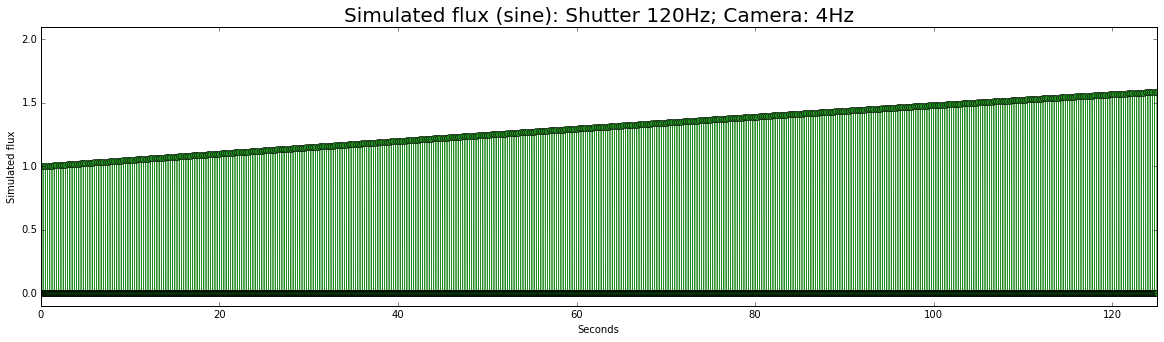

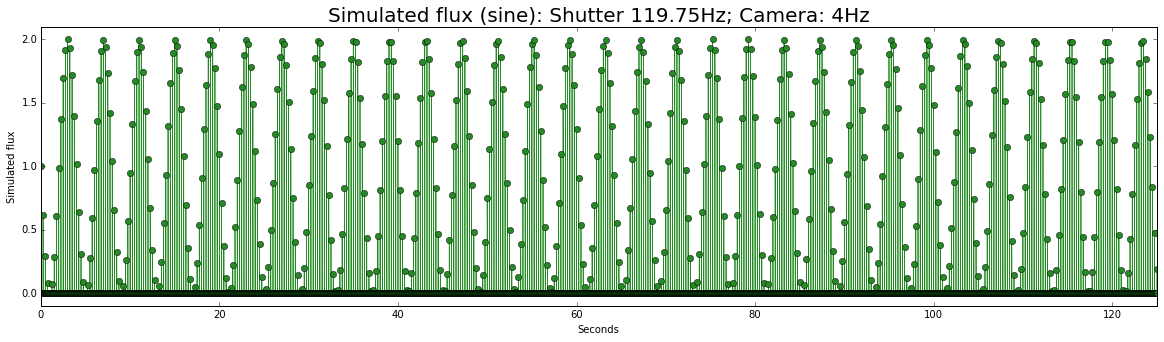

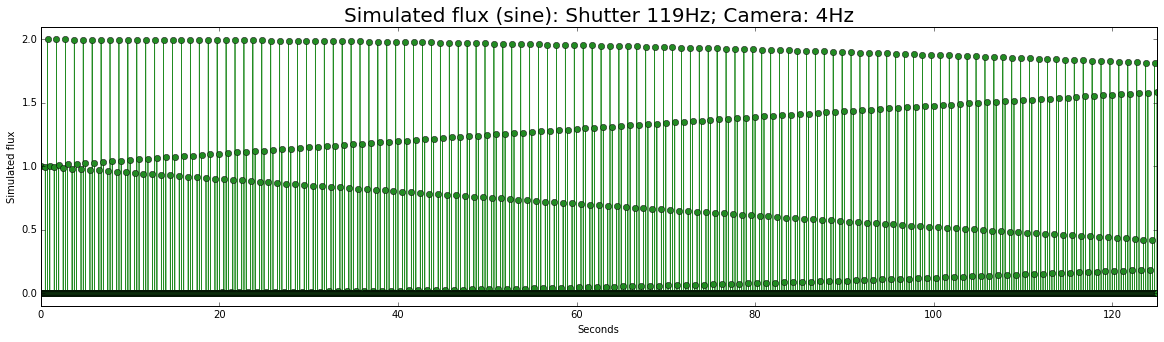

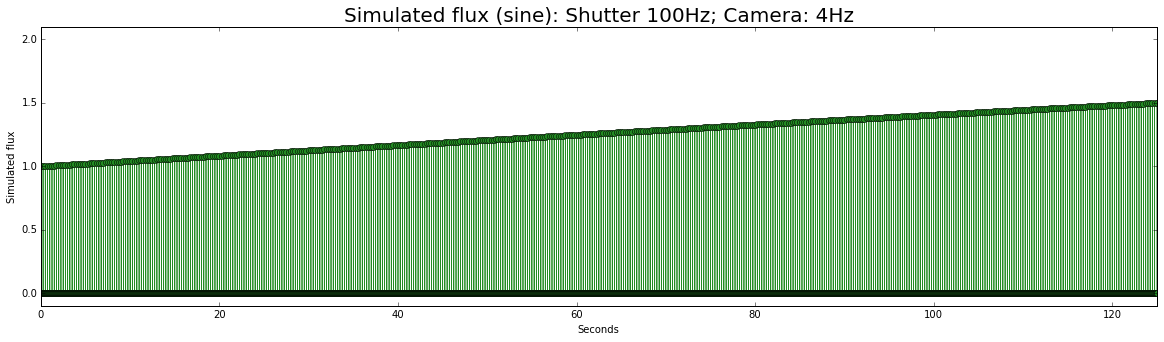

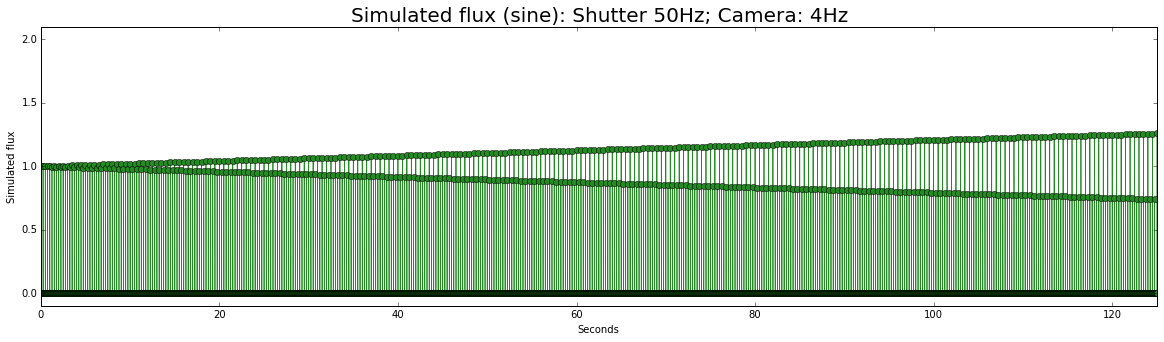

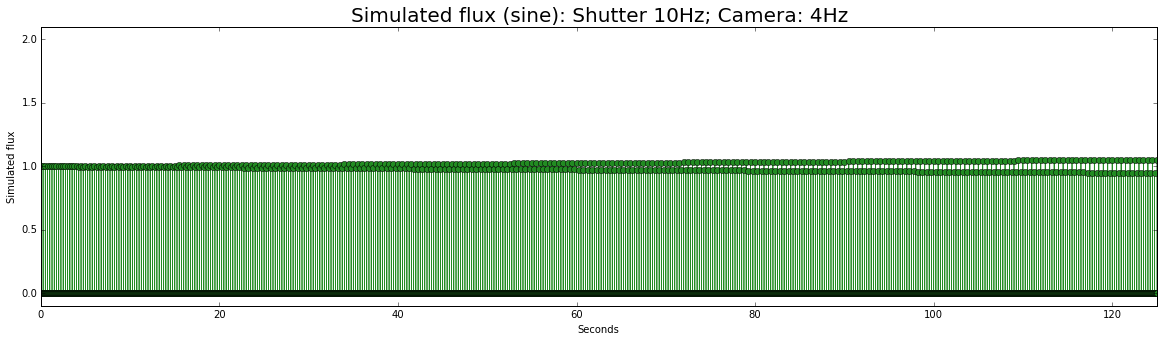

In [19]:
inter_sn4 = camera_meets_shutter_wave('sine', time, cam4, 4)

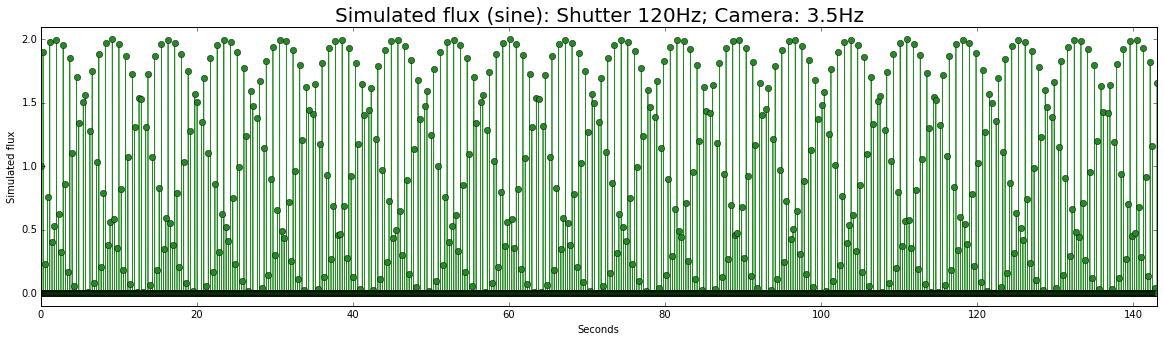

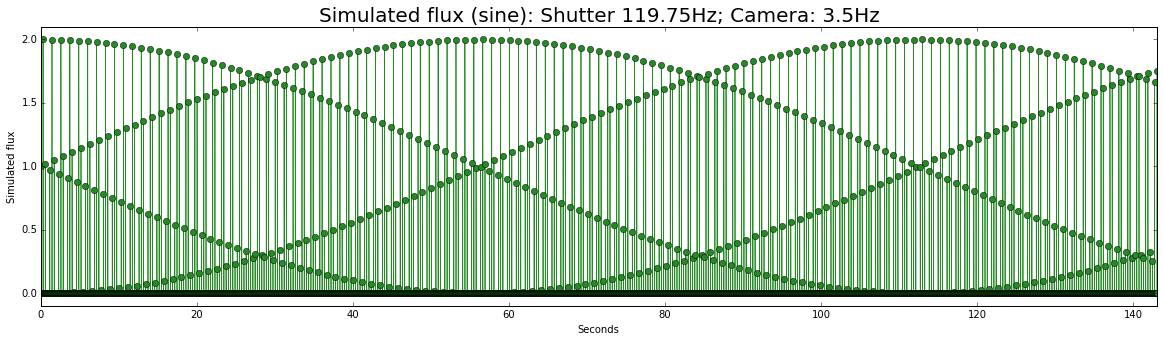

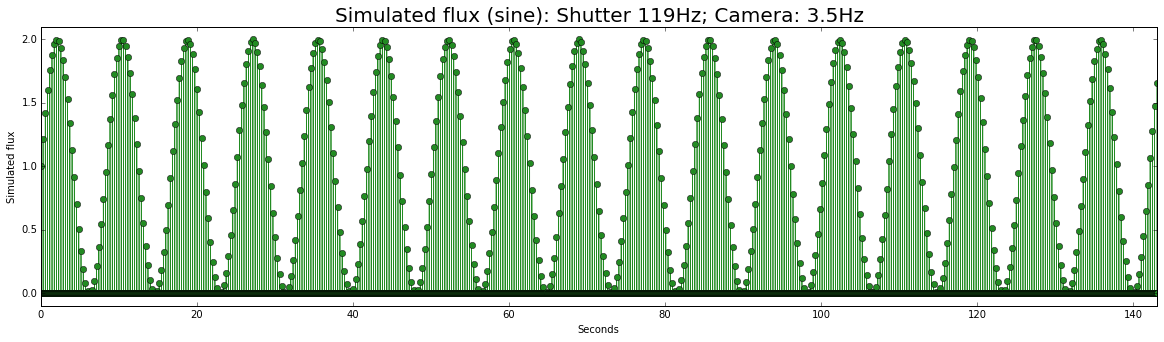

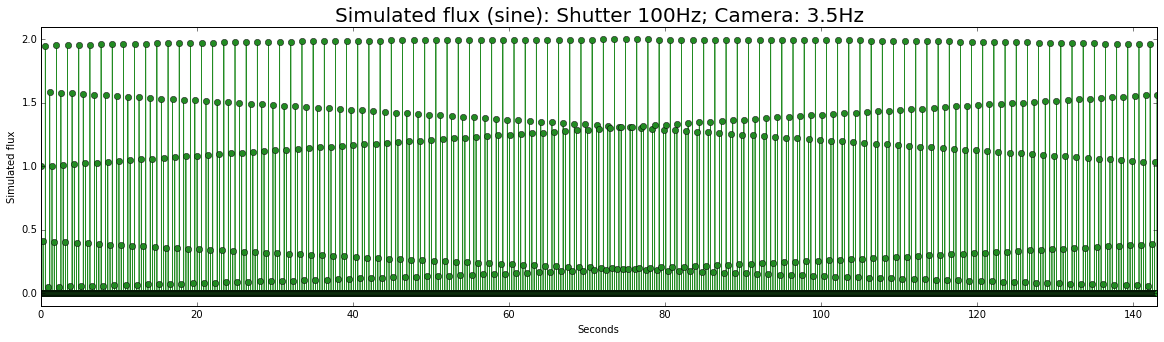

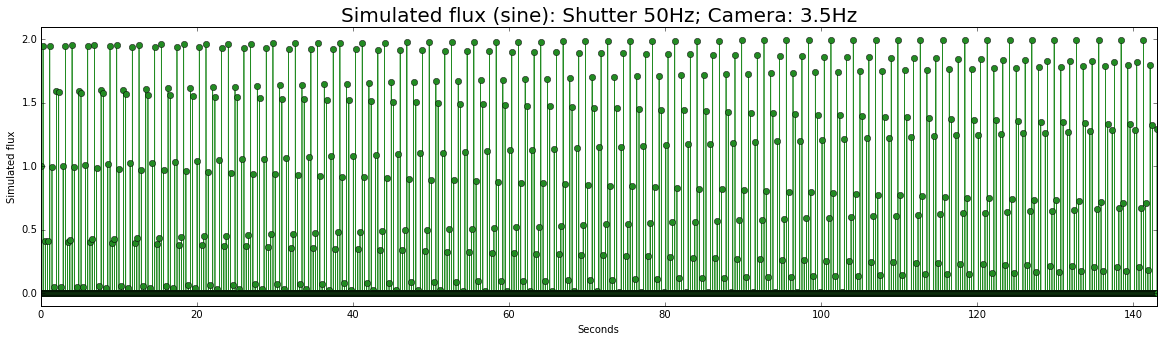

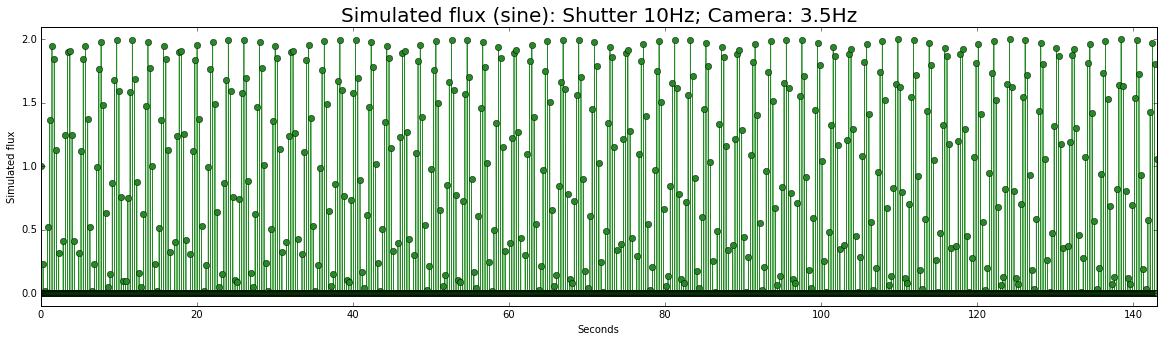

In [20]:
inter_sn35 = camera_meets_shutter_wave('sine', time, cam35, 3.5)

(1500000,)


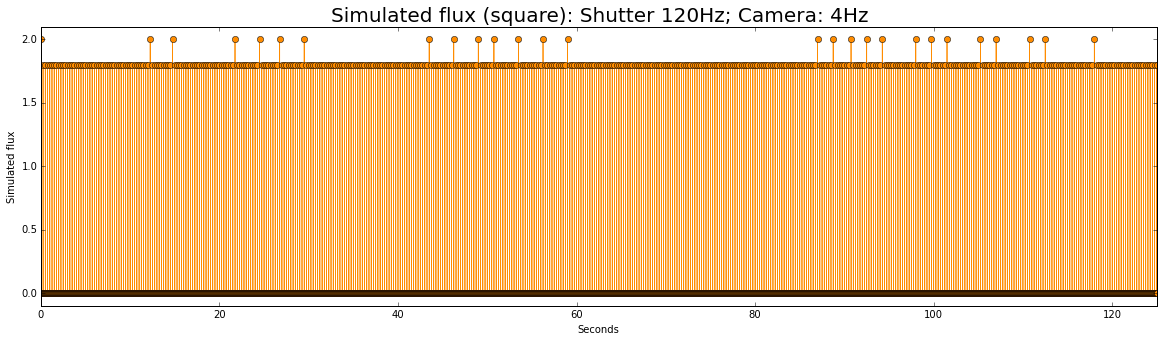

ValueError: operands could not be broadcast together with shapes (150000,) (1500000,) 

In [63]:
inter_sq4 = camera_meets_shutter_wave('square', time2, cam4_05ms, 4)

In [ ]:
inter_sq35 = camera_meets_shutter_wave('square', time2, cam35_05ms, 3.5)

## Residuals (divided by sine wave)

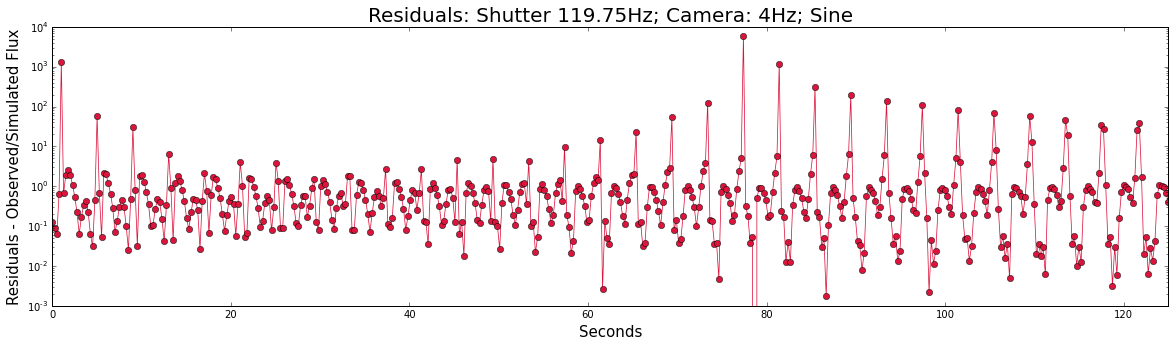

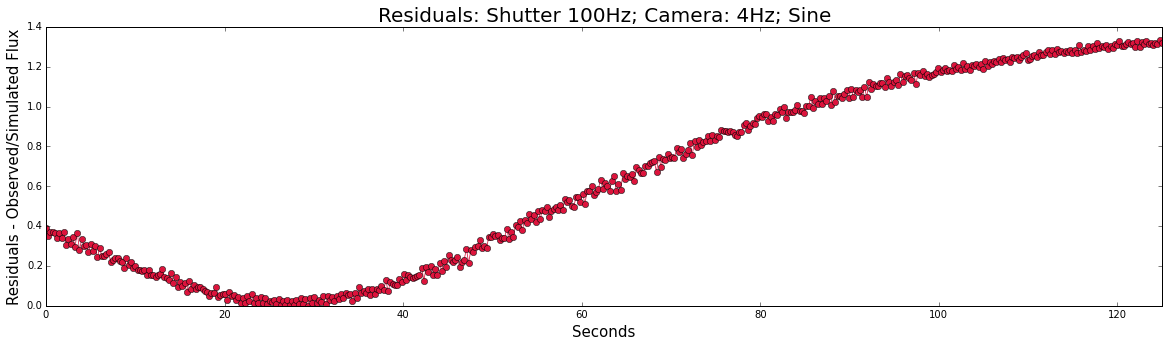

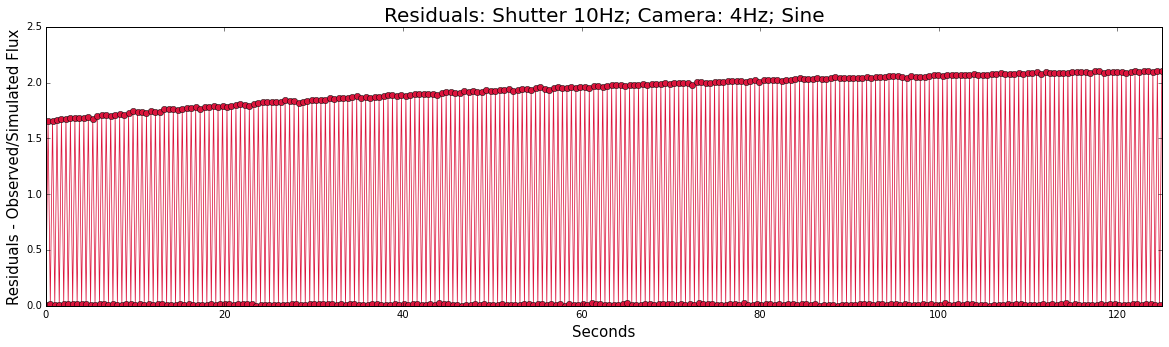

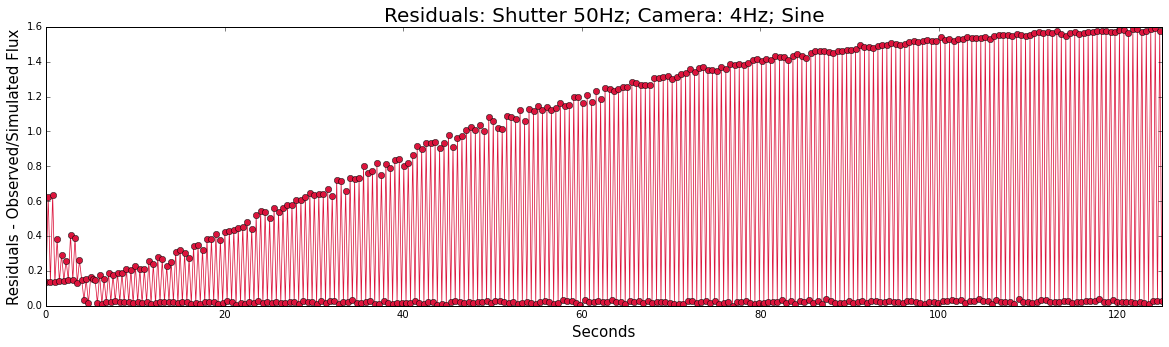

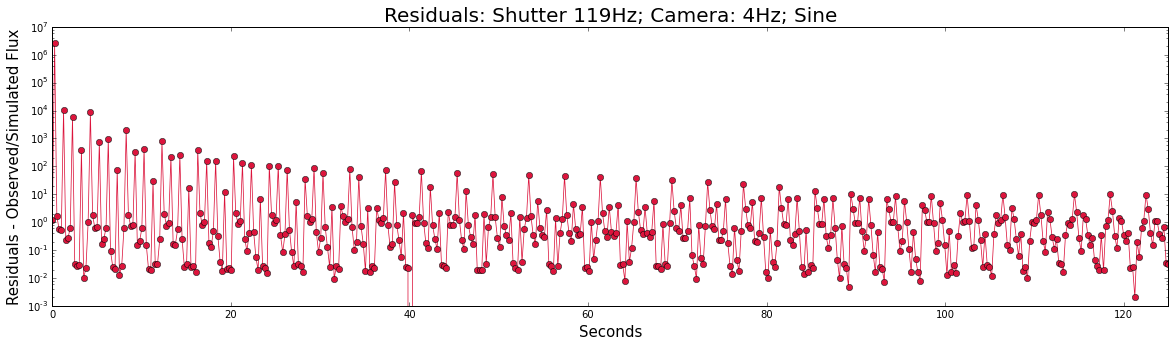

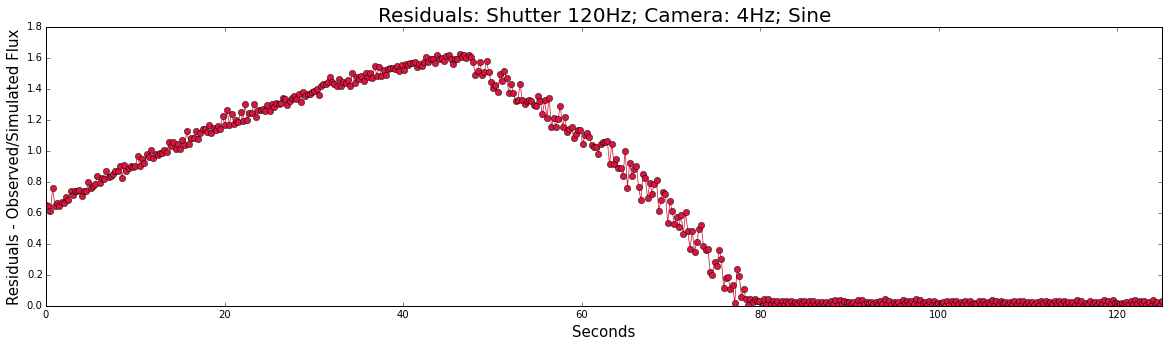

In [64]:
# Divide the observed time series by the simulated sine wave
# 4 Hz

res_sn4 = {}

for key, value in flux4.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 250ms interval
    inter_sn4[key] = inter_sn4[key][np.arange(125000)]
    res_sn4[key] = value/inter_sn4[key][np.arange(125000)%250==0]
    
    pl.figure(figsize=(20,5))
    if np.max(res_sn4[key])>2.2:
        pl.yscale('log')
    else:
        pass
    pl.plot(runtime4, res_sn4[key], '-', color='crimson', linewidth=0.75)
    pl.plot(runtime4, res_sn4[key], 'o', color='crimson')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+str(key)+'Hz; Camera: 4Hz; Sine', fontsize=20)
    pl.xlim(0,125)
    pl.show()

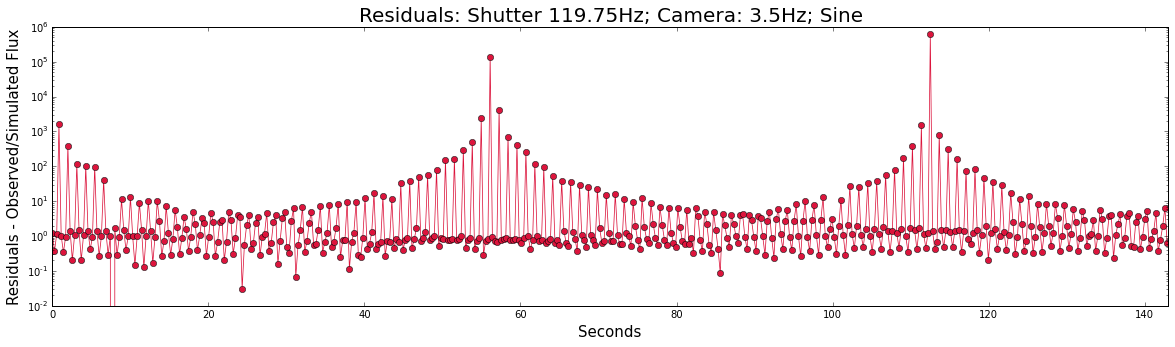

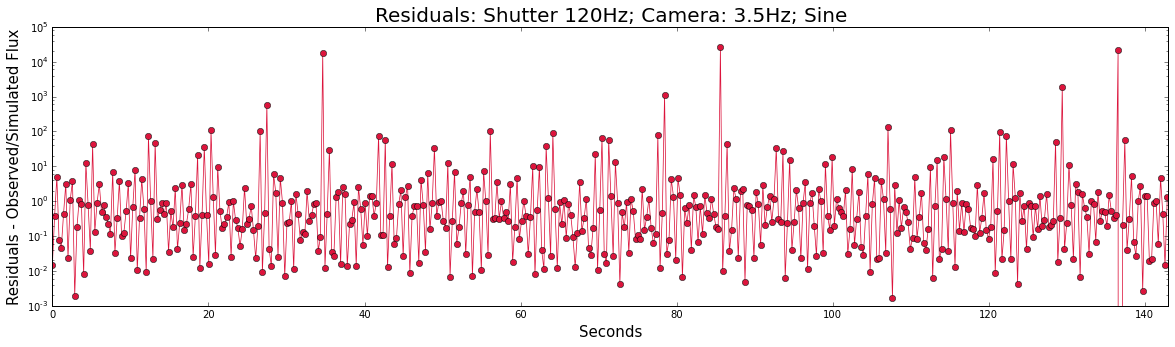

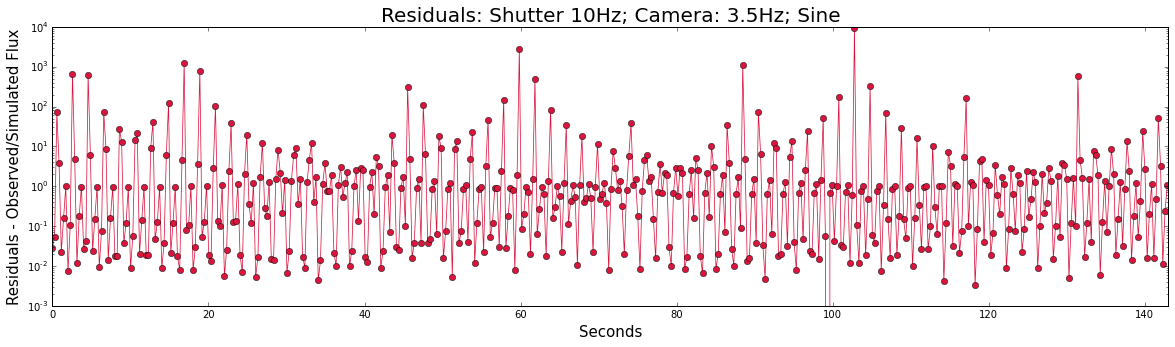

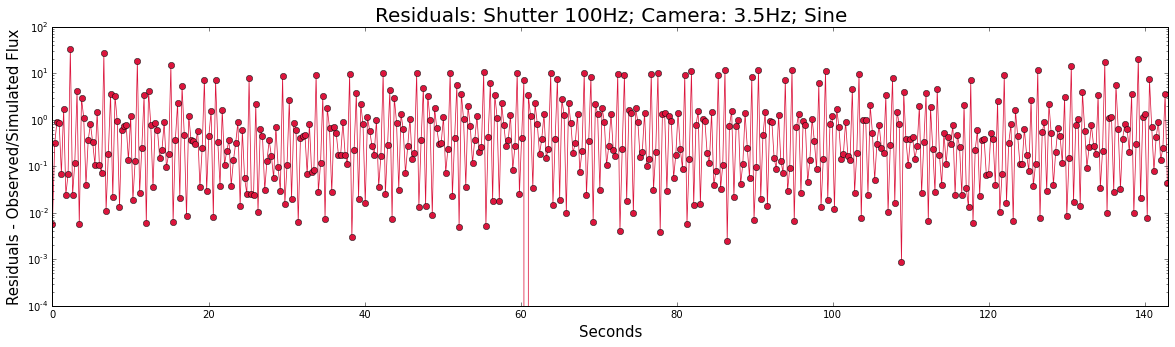

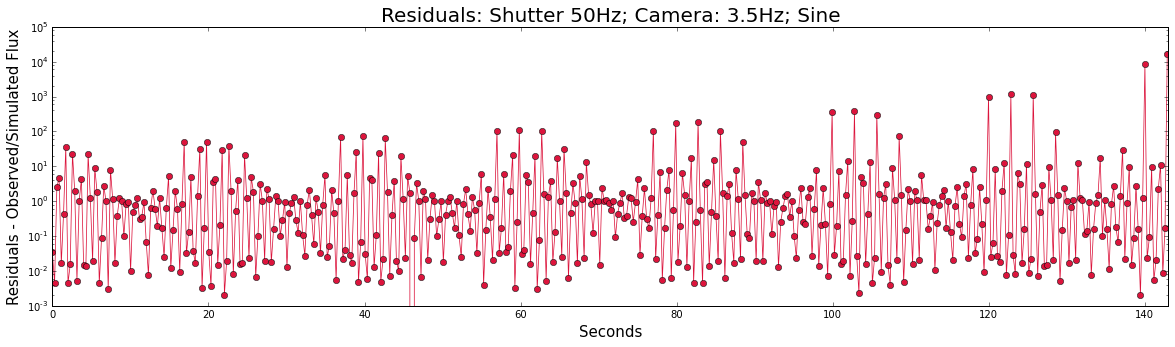

In [66]:
# Divide the observed time series by the simulated sine wave
# 3.5 Hz

res_sn35 = {}

for key, value in flux35.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 286ms interval
    inter_sn35[key] = inter_sn35[key][np.arange(143000)]
    res_sn35[key] = value/inter_sn35[key][np.arange(143000)%286==0]
    
    pl.figure(figsize=(20,5))
    pl.yscale('log')
    pl.plot(runtime35, res_sn35[key], '-', color='crimson', linewidth=0.75)
    pl.plot(runtime35, res_sn35[key], 'o', color='crimson')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+str(key)+'Hz; Camera: 3.5Hz; Sine', fontsize=20)
    xlim(0,143)
    pl.show()

## Residuals (divided by square wave)

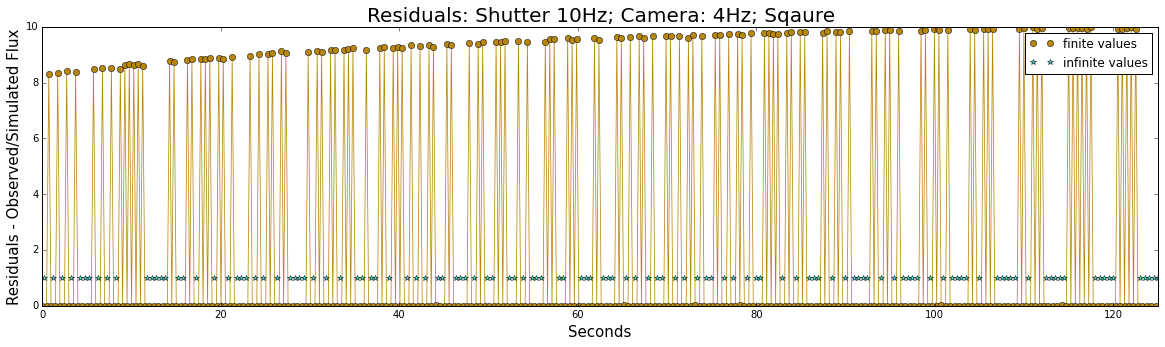

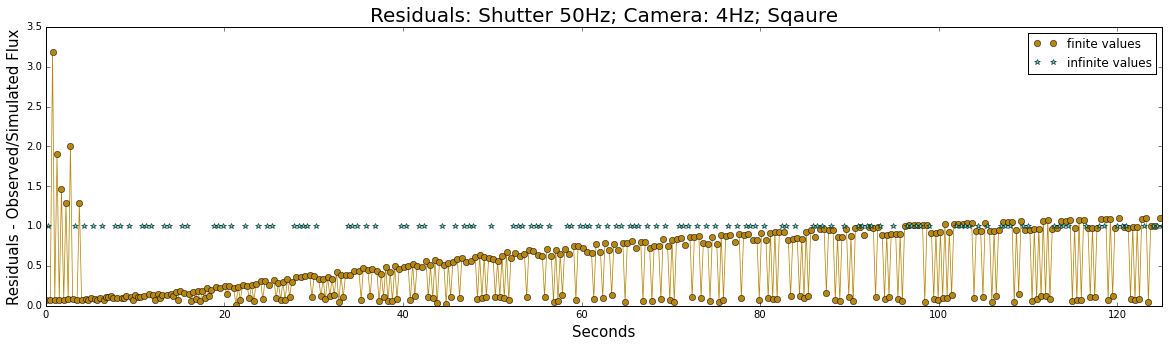

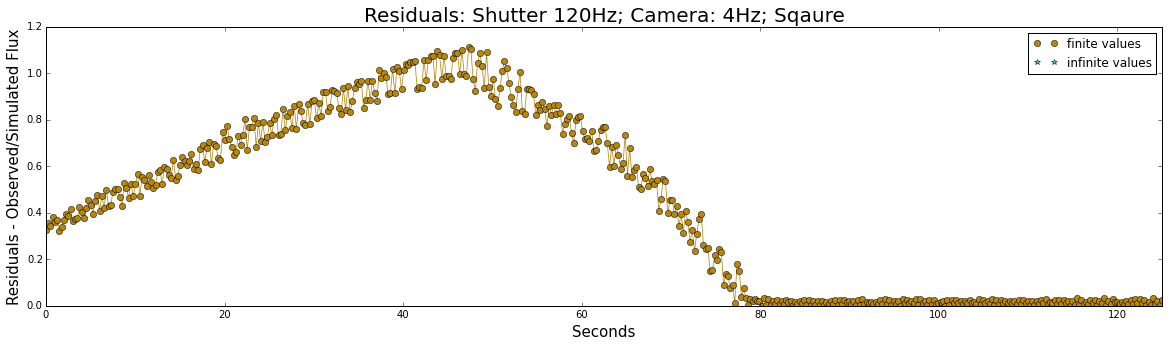

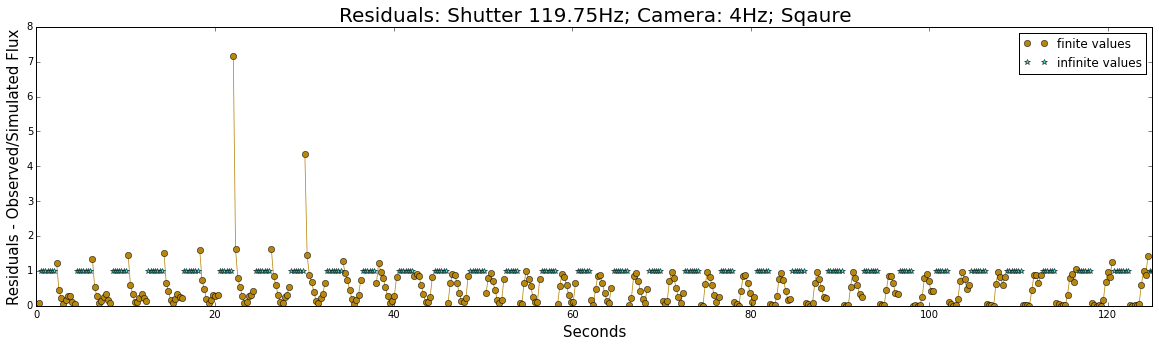

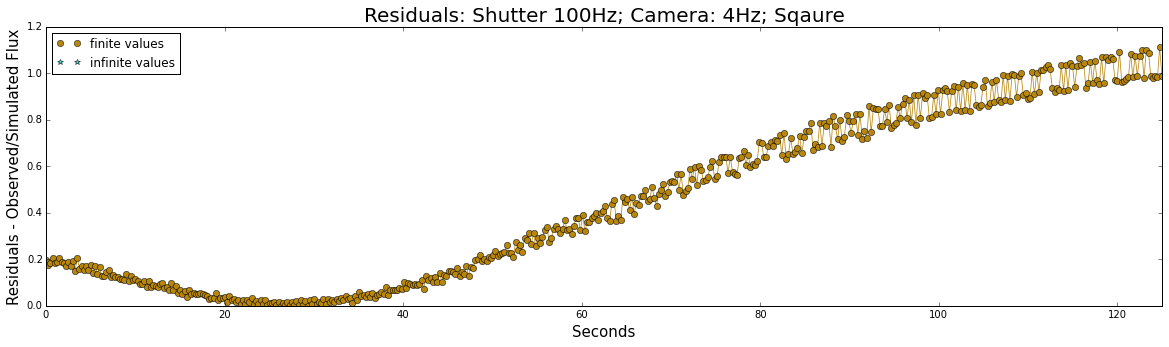

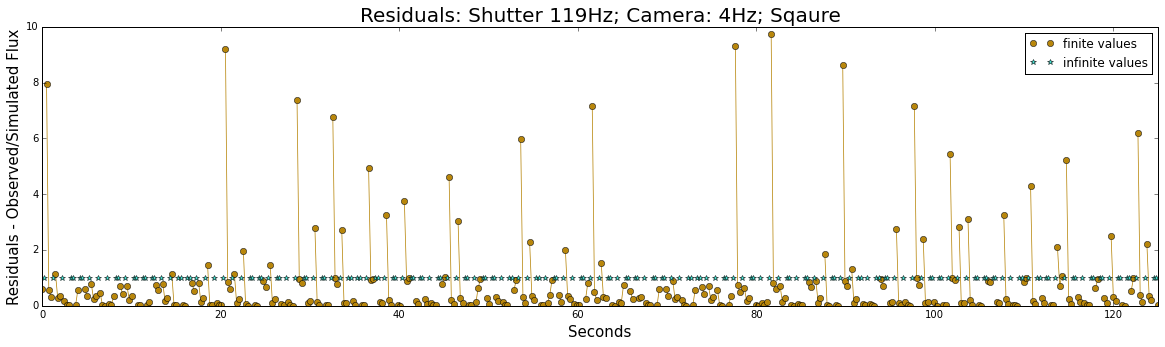

In [23]:
# Divide the observed time series by the simulated square wave
# 4 Hz

res_sq4 = {}

for key, value in flux4.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the square wave over each 250ms interval
    inter_sq4[key] = inter_sq4[key][np.arange(125000)]
    res_sq4[key] = value/inter_sq4[key][np.arange(125000)%250==0]
    
    if value.shape != res_sq4[key].shape:
        print "Residuals need to have the same length as runtime!"
        break
    
    pl.figure(figsize=(20,5))
    pl.plot(runtime4, res_sq4[key], '-', color='darkgoldenrod', linewidth=0.75)
    pl.plot(runtime4, res_sq4[key], 'o', color='darkgoldenrod', label='finite values')
    
    inf_idx = np.where(res_sq4[key]==inf)[0]
    pl.plot(runtime4[inf_idx], np.ones(len(inf_idx)), '*', c='turquoise', label='infinite values')
    
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+str(key)+'Hz; Camera: 4Hz; Sqaure', fontsize=20)
    pl.legend(loc='best')
    pl.xlim(0,125)
    pl.show()

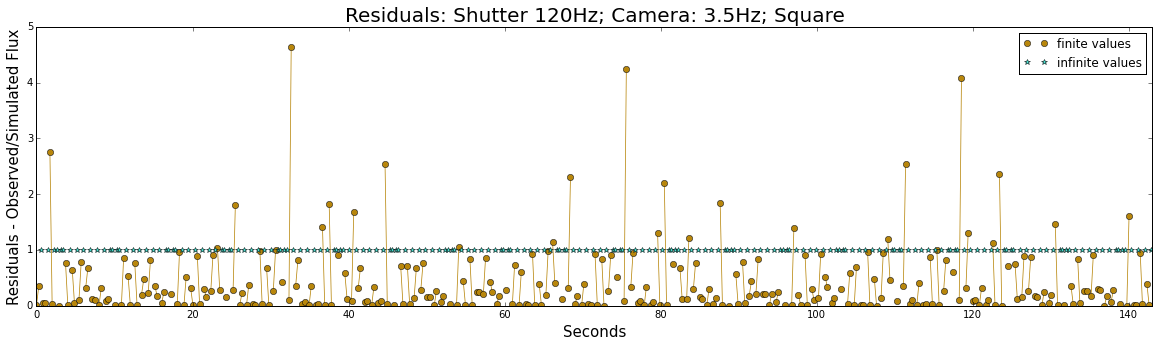

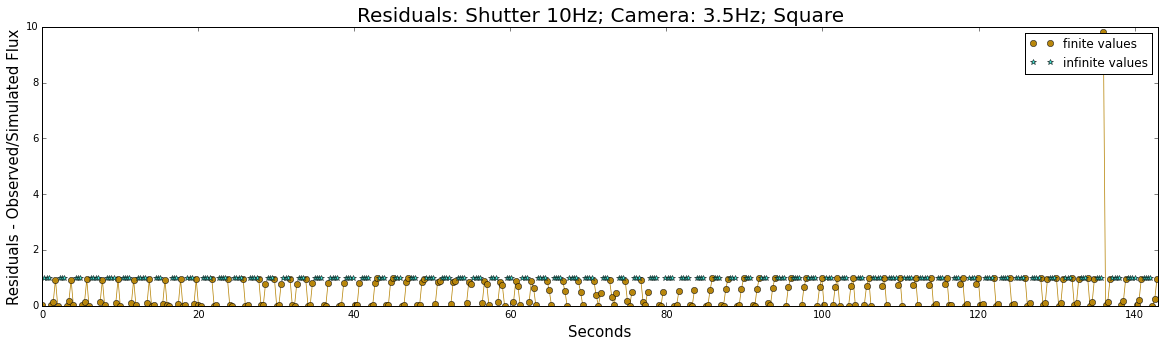

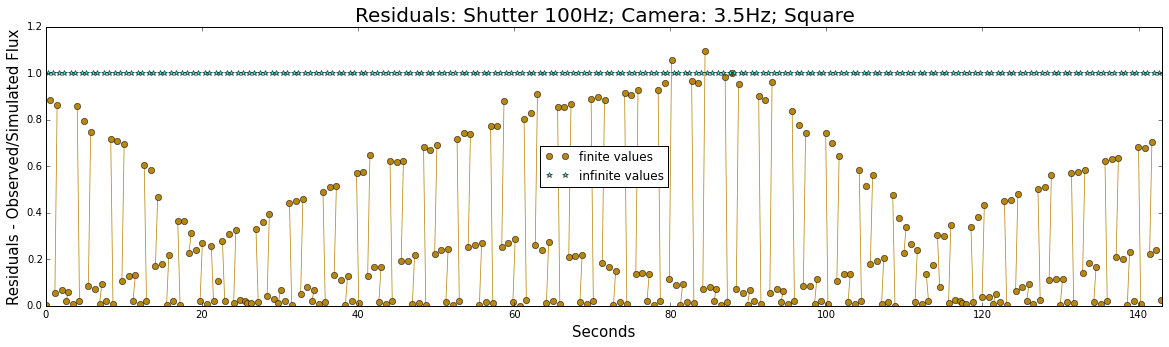

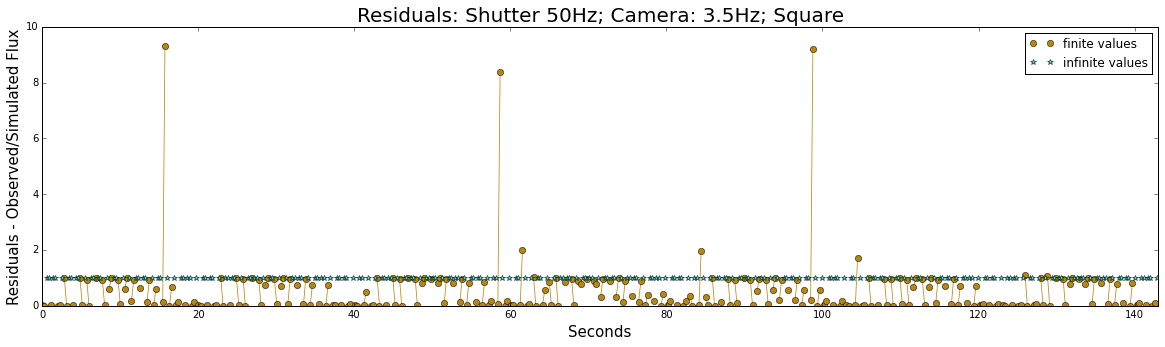

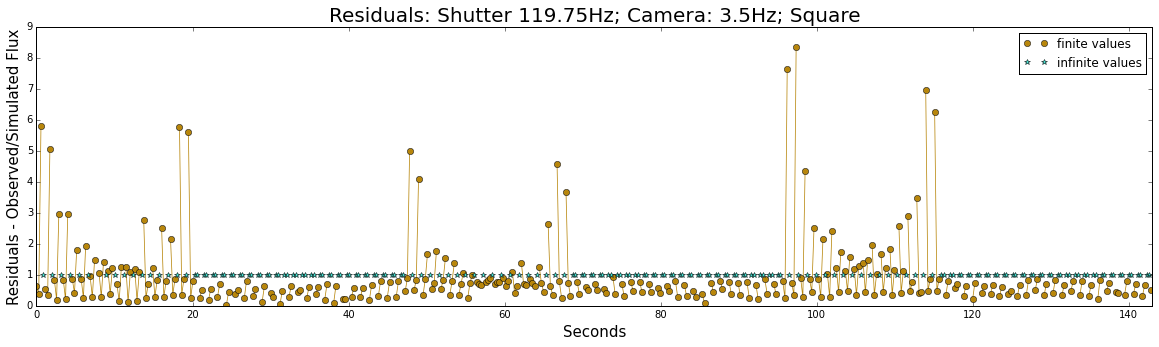

In [24]:
# Divide the observed time series by the simulated square wave
# 3.5 Hz

res_sq35 = {}

for key, value in flux35.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the square wave over each 286ms interval
    if key!='119': # remember we had an issue with this one
        inter_sq35[key] = inter_sq35[key][np.arange(143000)]
        res_sq35[key] = value/inter_sq35[key][np.arange(143000)%286==0]

        if runtime35.shape != res_sq35[key].shape:
            print "Residuals need to have the same length as runtime!"
            break
            
        pl.figure(figsize=(20,5))
        pl.plot(runtime35, res_sq35[key], '-', color='darkgoldenrod', linewidth=0.75)
        pl.plot(runtime35, res_sq35[key], 'o', color='darkgoldenrod', label='finite values')
        
        inf_idx = np.where(res_sq35[key]==inf)[0]
        pl.plot(runtime35[inf_idx], np.ones(len(inf_idx)), '*', c='turquoise', label='infinite values')
    
        pl.xlabel("Seconds", fontsize=15)
        pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
        pl.title('Residuals: Shutter '+str(key)+'Hz; Camera: 3.5Hz; Square', fontsize=20)
        pl.xlim(0,143)
        pl.legend(loc='best')
        pl.show()
    else:
        pass

### It is clear that the gaps in the wave are caused by the infinite results in the divisions

## Folding the flux time series to 2 shutter cycles

In [88]:
def folding(flux, runtime, freq):
    runtime_mod = (1000*runtime)%(2/freq)
    sorted_idx = np.asarray([i[0] for i in sorted(enumerate(runtime_mod), key=lambda x:x[1])])
    return flux[sorted_idx], 1000*runtime_mod[sorted_idx] # return time in microseconds

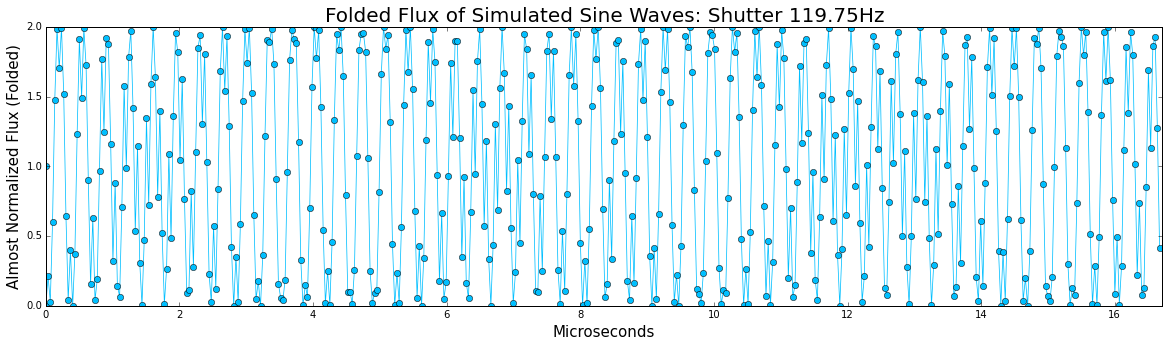

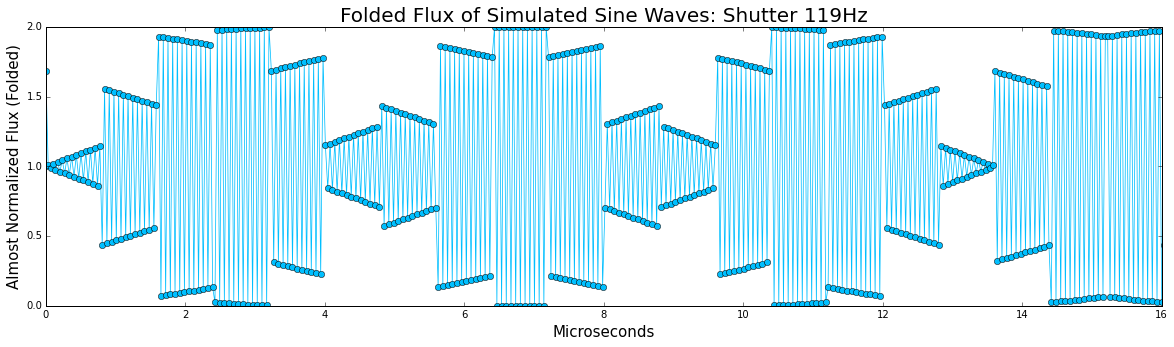

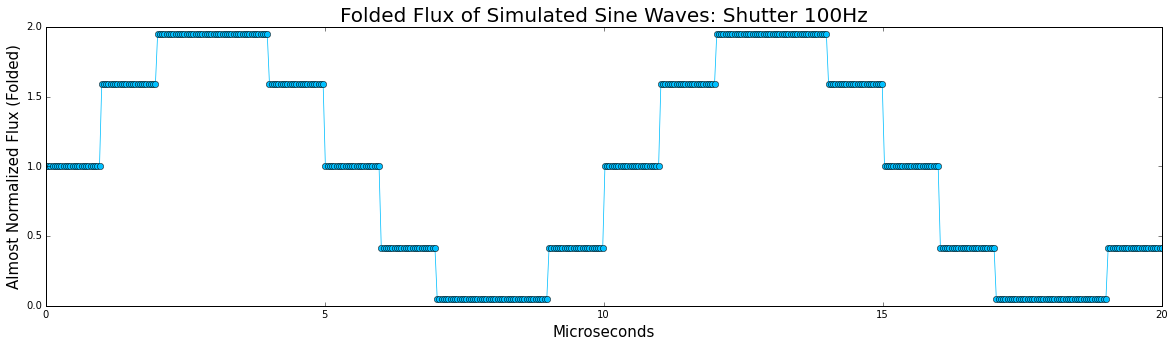

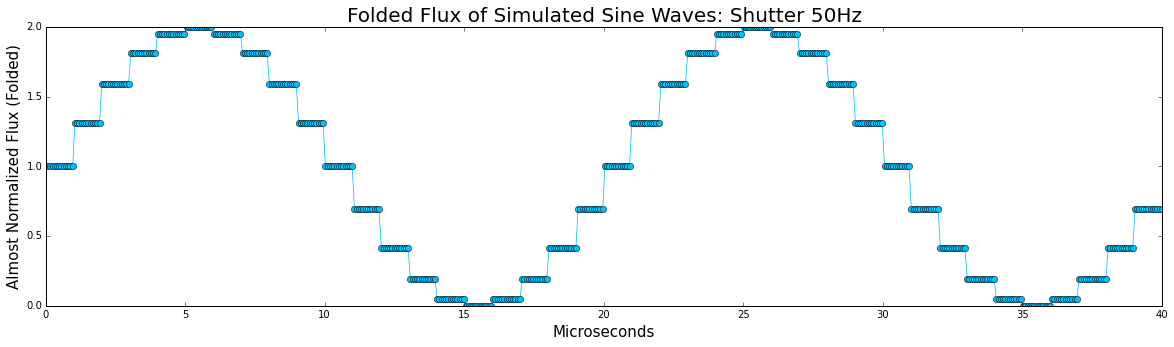

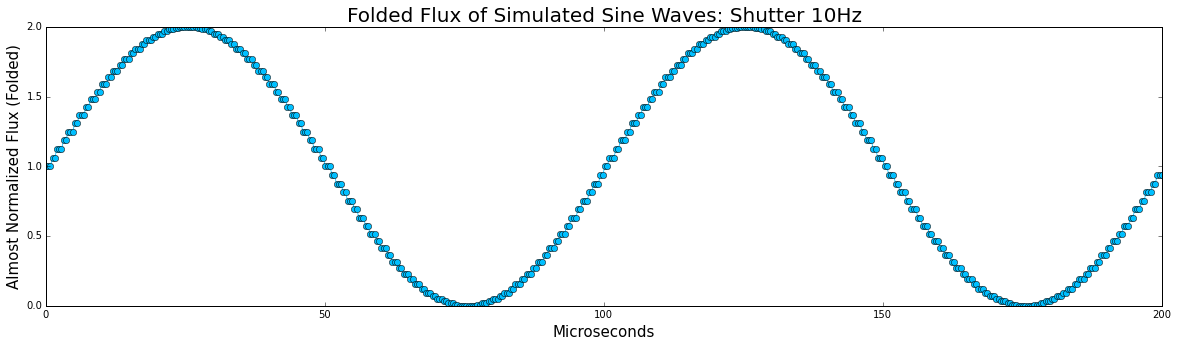

In [89]:
# Testing the folding algorithm on simulated sine waves
# 4Hz
# The original runtime is by seconds, so we need to multiply by 1000 before modding by 2 shuttercycles

for i in shutter:
    sim_flux, sim_time = folding(sim_wave('sine', time, i), runtime4, float(i))
    pl.figure(figsize=(20,5))
    pl.plot(sim_time, sim_flux, '-', color='deepskyblue', linewidth=0.75)
    pl.plot(sim_time, sim_flux, 'o', color='deepskyblue')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux of Simulated Sine Waves: Shutter '+str(i)+'Hz', fontsize=20)
    pl.xlim(0,2000/i)
    pl.show()

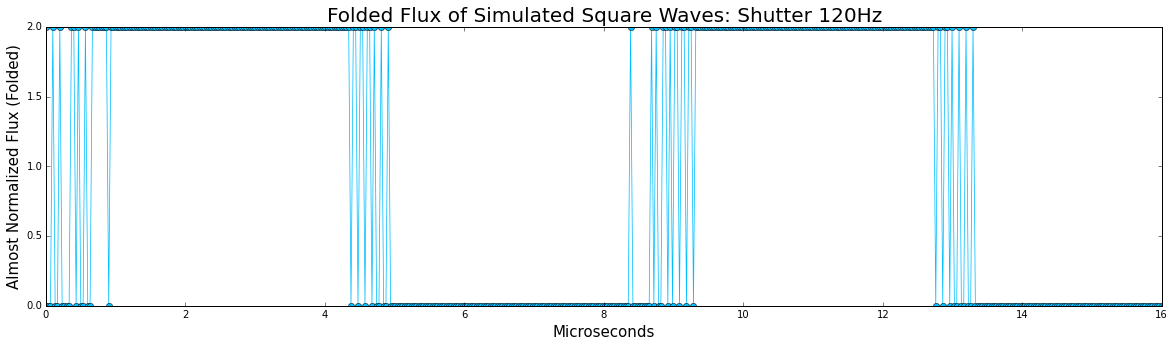

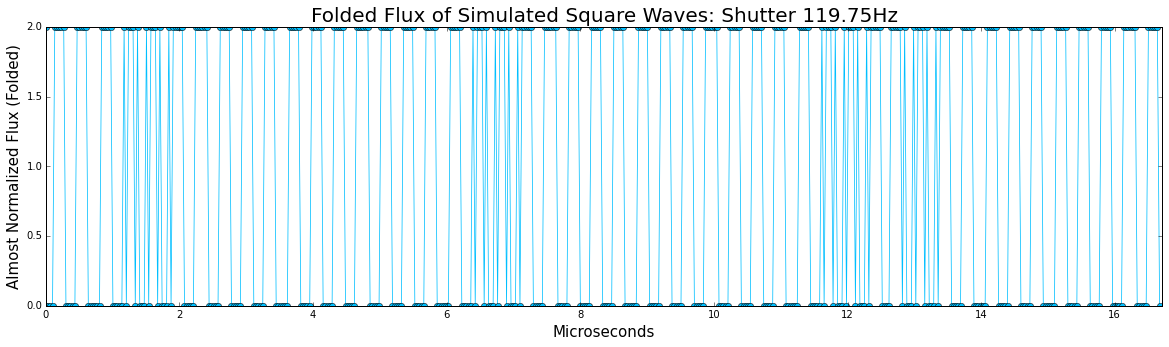

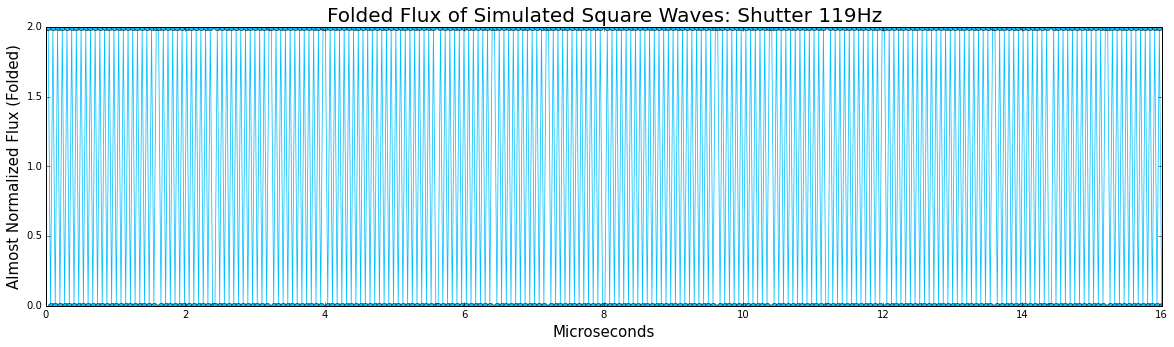

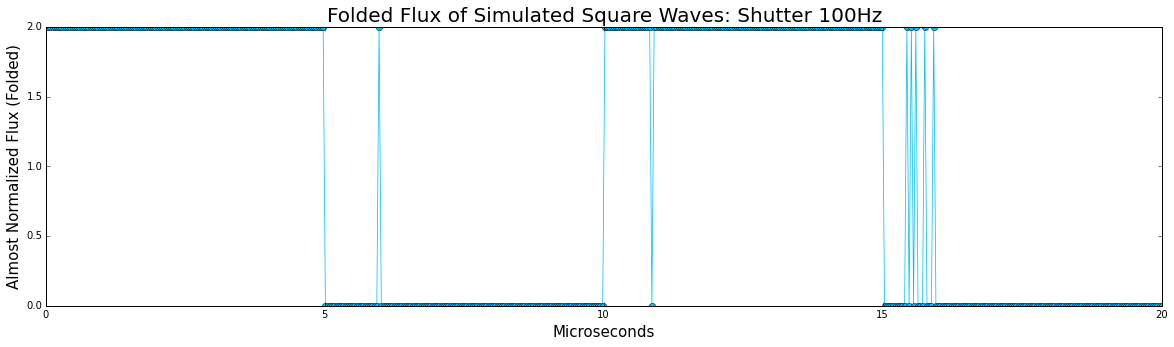

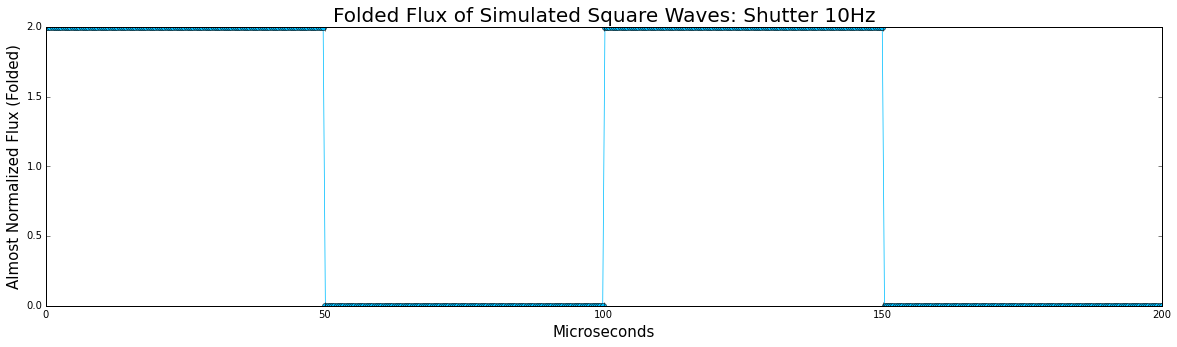

In [90]:
# Testing the folding algorithm on simulated square waves
# 4Hz
# The original runtime is by seconds, so we need to multiply by 1000 before modding by 2 shuttercycles

for i in shutter:
    sim_flux, sim_time = folding(sim_wave('square', time, i), runtime4, float(i))
    pl.figure(figsize=(20,5))
    pl.plot(sim_time, sim_flux, '-', color='deepskyblue', linewidth=0.75)
    pl.plot(sim_time, sim_flux, 'o', color='deepskyblue')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux of Simulated Square Waves: Shutter '+str(i)+'Hz', fontsize=20)
    pl.xlim(0,2000/i)
    pl.show()

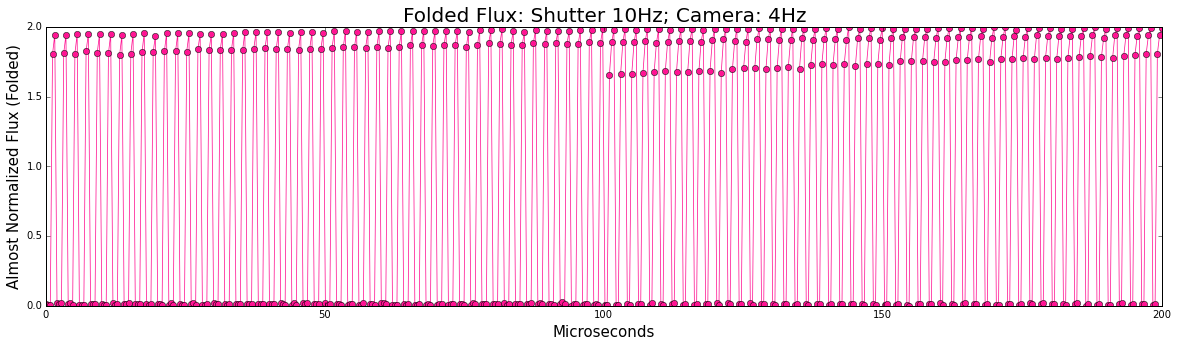

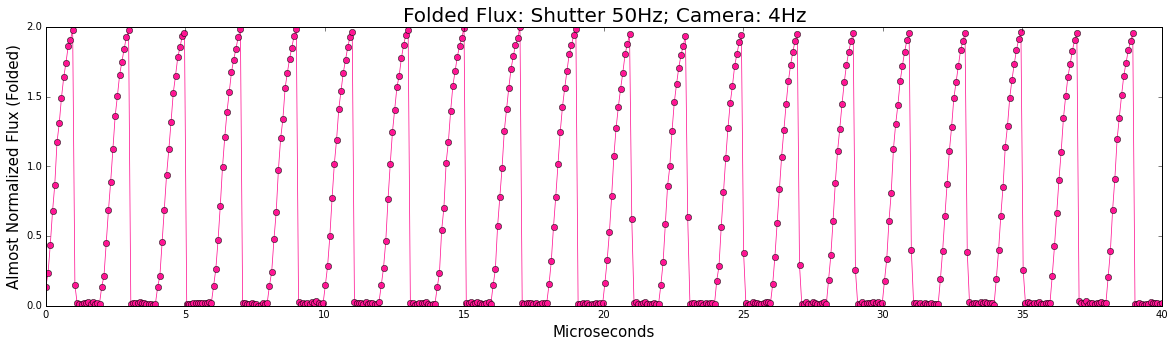

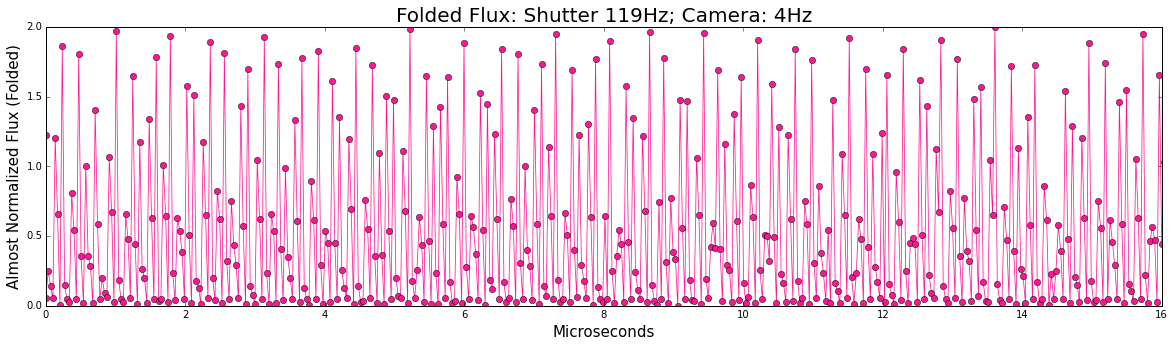

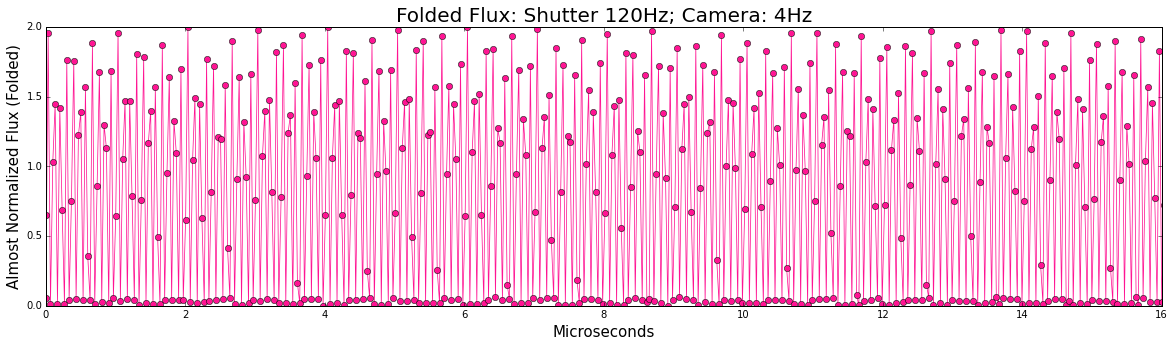

In [93]:
# Actual flux
# 4Hz
# The original runtime is by seconds, so we need to multiply by 1000 before modding by 2 shuttercycles

folded_4 = {}

for key, value in flux4.iteritems():
    folded_4[key] = {}
    folded_4[key]['flux'], folded_4[key]['time'] = folding(value, runtime4, float(key))
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_4[key]['time'], folded_4[key]['flux'], '-', color='deeppink', linewidth=0.75)
    pl.plot(folded_4[key]['time'], folded_4[key]['flux'], 'o', color='deeppink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux: Shutter '+str(key)+'Hz; Camera: 4Hz', fontsize=20)
    pl.xlim(0,2000/key)
    pl.show()

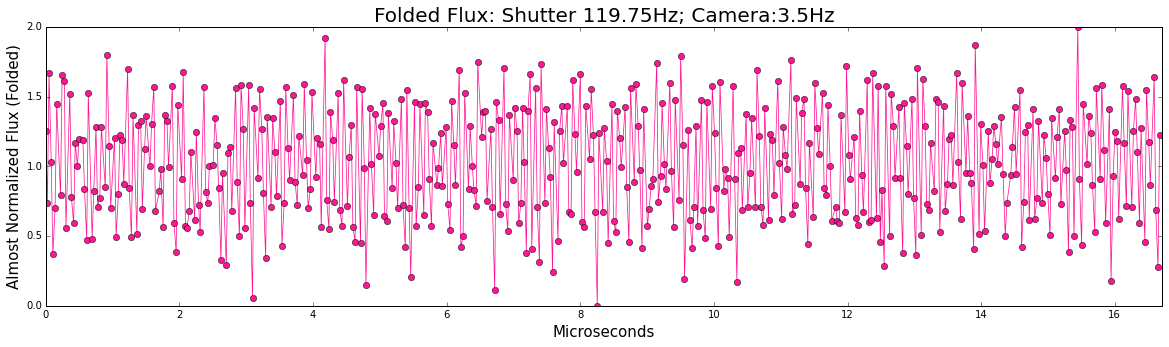

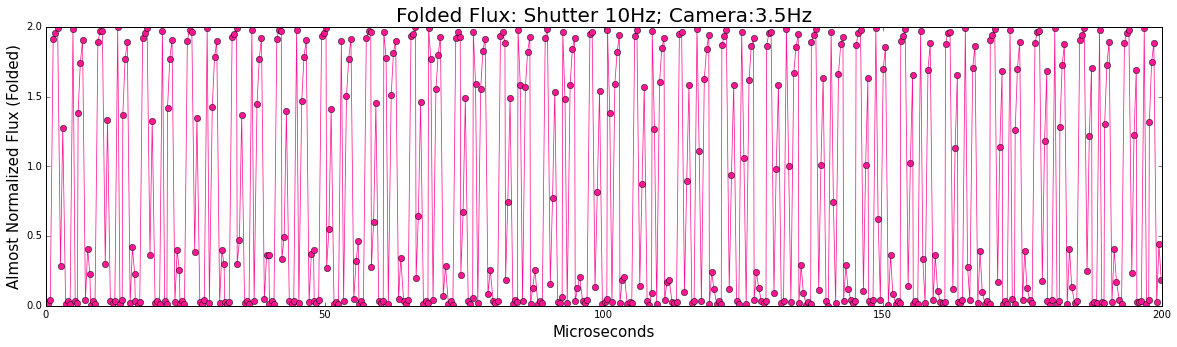

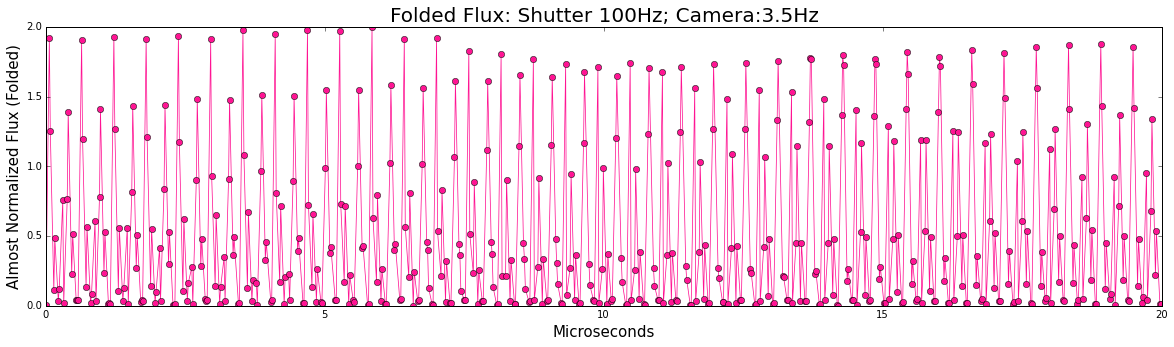

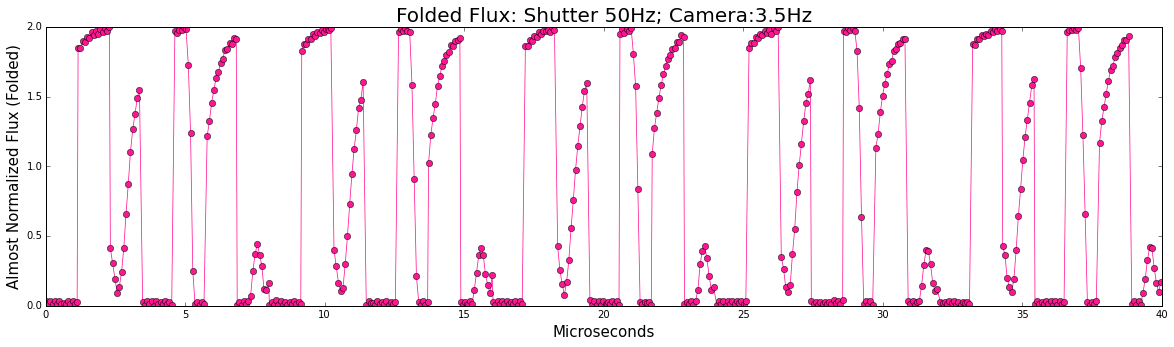

In [96]:
# 3.5Hz

folded_35 = {}

for key, value in flux35.iteritems():
    folded_35[key] = {}
    folded_35[key]['flux'], folded_35[key]['time'] = folding(value, runtime35, float(key))
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_35[key]['time'], folded_35[key]['flux'], '-', color='deeppink', linewidth=0.75)
    pl.plot(folded_35[key]['time'], folded_35[key]['flux'], 'o', color='deeppink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux: Shutter '+str(key)+'Hz; Camera:3.5Hz', fontsize=20)
    pl.xlim(0, 2000/key)
    pl.show()